
# Caricamento libri


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import re
import os

def estrai_contenuto_gutenberg(testo):
    pattern_start = r'\*\*\* START OF (?:THE |THIS )?PROJECT GUTENBERG EBOOK.*?\*\*\*'
    pattern_end = r'\*\*\* END OF THE PROJECT GUTENBERG EBOOK '

    match_start = re.search(pattern_start, testo, re.IGNORECASE | re.DOTALL)
    match_end = re.search(pattern_end, testo, re.IGNORECASE | re.DOTALL)

    if match_start and match_end:
        return testo[match_start.end():match_end.start()].strip()
    elif match_start:
        return testo[match_start.end():].strip()
    elif match_end:
        return testo[:match_end.start()].strip()
    else:
        return testo

def carica_tutti_i_libri(path_input, cartella_output):
    autori = ["primo autore", "secondo autore", "terzo autore"]

    # Crea cartella output se non esistente
    os.makedirs(cartella_output, exist_ok=True)

    libri_raggruppati = {autore: [] for autore in autori}

    for autore in autori:
        cartella = f"{path_input}{autore}"

        try:
            file_txt = [f for f in os.listdir(cartella)
                       if f.endswith('.txt')]

            if not file_txt:
                continue

            file_txt.sort()

            for nome_file in file_txt:
                percorso_completo = os.path.join(cartella, nome_file)

                try:
                    with open(percorso_completo, "r", encoding="utf-8") as f:
                        testo_completo = f.read()

                    contenuto_libro = estrai_contenuto_gutenberg(testo_completo)

                    if len(contenuto_libro) > 100:
                        libri_raggruppati[autore].append(contenuto_libro)

                except Exception:
                    continue

        except (FileNotFoundError, Exception):
            continue

    # Salva file combinati
    for autore, libri_autore in libri_raggruppati.items():
        if libri_autore:
            nome_file = f"{autore.replace(' ', '_')}_tutti_i_libri.txt"
            percorso_file = os.path.join(cartella_output, nome_file)

            with open(percorso_file, "w", encoding="utf-8") as f:
                f.write("\n\n" + "="*80 + "\n\n".join(libri_autore))

    return libri_raggruppati

# Esecuzione
path_trainings = "/content/drive/MyDrive/libri_training/"
cartella_output = "/content/drive/MyDrive/libri_puliti_training"

libri_raggruppati = carica_tutti_i_libri(path_trainings, cartella_output)

# Riepilogo essenziale
for autore, libri in libri_raggruppati.items():
    if libri:
        caratteri_totali = sum(len(libro) for libro in libri)
        print(f"{autore}: {len(libri)} libri, {caratteri_totali:,} caratteri")

primo autore: 5 libri, 2,274,448 caratteri
secondo autore: 7 libri, 3,173,605 caratteri
terzo autore: 8 libri, 2,208,855 caratteri


# Funzione di estrazione paragrafi


#Preparazione dati: funzioni varie

In [11]:
import re
import os
from sklearn.model_selection import train_test_split

def crea_corpus_word_embedding(
    cartella_libri_puliti_training,
    cartella_libri_puliti_test_val,
    cartella_output_finale,
    min_words_embedding=50,
    max_words_embedding=100,
    debug=False
):
    """
    Crea corpus unificato per word embedding FastText
    Include tutti i paragrafi di tutti gli autori (più permissivo sui limiti)
    """
    print(f"\n{'='*50}")
    print(f"CREAZIONE CORPUS per WORD EMBEDDING")
    print(f"{'='*50}")
    print(f"Parametri: {min_words_embedding}-{max_words_embedding} parole per paragrafo")

    # Cartella per i file di embedding
    cartella_embedding = os.path.join(cartella_output_finale, "word_embedding_corpus")
    os.makedirs(cartella_embedding, exist_ok=True)

    autori = ["primo autore", "secondo autore", "terzo autore"]

    # Lista per raccogliere tutti i paragrafi
    tutti_paragrafi = []
    paragrafi_per_autore = {}

    # Processa entrambe le cartelle (training + test/val)
    cartelle_source = [
        ("training", cartella_libri_puliti_training),
        ("test_val", cartella_libri_puliti_test_val)
    ]

    for tipo_set, cartella_source in cartelle_source:
        print(f"\n  Processando set {tipo_set}:")

        for autore in autori:
            nome_file_autore = f"{autore.replace(' ', '_')}_tutti_i_libri.txt"
            file_source = os.path.join(cartella_source, nome_file_autore)

            if os.path.exists(file_source):
                # Estrai paragrafi con limiti più permissivi
                paragrafi_autore = estrai_paragrafi_da_file_corretto(
                    file_source,
                    min_words=min_words_embedding,
                    max_words=max_words_embedding,
                    debug=debug
                )

                print(f"    {autore} ({tipo_set}): {len(paragrafi_autore)} paragrafi")

                # Aggiungi alla collezione totale
                tutti_paragrafi.extend(paragrafi_autore)

                # Tieni traccia per autore
                if autore not in paragrafi_per_autore:
                    paragrafi_per_autore[autore] = []
                paragrafi_per_autore[autore].extend(paragrafi_autore)
            else:
                print(f"    {autore} ({tipo_set}): File non trovato")

    # Salva corpus unificato per FastText
    print(f"\nSalvataggio corpus per word embedding:")

    # 1. Corpus completo (tutti gli autori insieme)
    file_corpus_completo = os.path.join(cartella_embedding, "corpus_completo.txt")
    with open(file_corpus_completo, "w", encoding="utf-8") as f:
        for paragrafo in tutti_paragrafi:
            # Ogni paragrafo su una riga (standard per FastText)
            f.write(paragrafo.replace('\n', ' ') + '\n')

    print(f"  ✓ Corpus completo: {len(tutti_paragrafi)} paragrafi → corpus_completo.txt")

    # 2. Corpus separati per autore (opzionale, utile per analisi)
    for autore, paragrafi in paragrafi_per_autore.items():
        nome_file_autore_corpus = f"corpus_{autore.replace(' ', '_')}.txt"
        file_corpus_autore = os.path.join(cartella_embedding, nome_file_autore_corpus)

        with open(file_corpus_autore, "w", encoding="utf-8") as f:
            for paragrafo in paragrafi:
                f.write(paragrafo.replace('\n', ' ') + '\n')

        print(f"  ✓ {autore}: {len(paragrafi)} paragrafi → {nome_file_autore_corpus}")

    # 3. Salva statistiche
    tutte_le_parole = []
    for paragrafo in tutti_paragrafi:
        parole = re.findall(r'\b\w+\b', paragrafo.lower())
        tutte_le_parole.extend(parole)

    vocabulary_unico = set(tutte_le_parole)

    file_stats = os.path.join(cartella_embedding, "corpus_statistics.txt")
    with open(file_stats, "w", encoding="utf-8") as f:
        f.write(f"STATISTICHE CORPUS WORD EMBEDDING\n")
        f.write(f"=====================================\n\n")
        f.write(f"Parametri estrazione: {min_words_embedding}-{max_words_embedding} parole/paragrafo\n\n")
        f.write(f"TOTALI:\n")
        f.write(f"  - Paragrafi: {len(tutti_paragrafi):,}\n")
        f.write(f"  - Parole totali: {len(tutte_le_parole):,}\n")
        f.write(f"  - Vocabulary unico: {len(vocabulary_unico):,}\n\n")
        f.write(f"PER AUTORE:\n")
        for autore, paragrafi in paragrafi_per_autore.items():
            f.write(f"  - {autore}: {len(paragrafi):,} paragrafi\n")

    print(f"\nStatistiche vocabulary:")
    print(f"  - Paragrafi totali: {len(tutti_paragrafi):,}")
    print(f"  - Parole totali: {len(tutte_le_parole):,}")
    print(f"  - Vocabulary unico: {len(vocabulary_unico):,}")

    return cartella_embedding

def conta_parole_correttamente(testo):
    """Conta le parole in modo accurato usando regex"""
    if not testo or not testo.strip():
        return 0

    # Rimuovi spazi extra e normalizza
    testo_pulito = re.sub(r'\s+', ' ', testo.strip())

    # Usa regex per trovare sequenze di caratteri alfanumerici
    parole = re.findall(r'\b\w+\b', testo_pulito)

    return len(parole)

def pulisci_paragrafo(paragrafo):
    """Pulisce un paragrafo mantenendo la leggibilità"""
    if not paragrafo:
        return ""

    # Rimuovi caratteri di controllo
    paragrafo = re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\x9f]', '', paragrafo)

    # Normalizza spazi multipli
    paragrafo = re.sub(r'\s+', ' ', paragrafo)

    # Rimuovi spazi all'inizio e fine
    paragrafo = paragrafo.strip()

    # Rimuovi linee che sono solo punteggiatura o numeri
    if re.match(r'^[^\w]*$', paragrafo) or re.match(r'^\d+\.?\s*$', paragrafo):
        return ""

    return paragrafo

def estrai_paragrafi_da_file_corretto(file_path, min_words=50, max_words=100, debug=False):
    """
    Estrae paragrafi validi da un singolo file con conteggio parole accurato
    """
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            testo = f.read()
    except Exception as e:
        print(f"Errore leggendo {file_path}: {e}")
        return []

    if debug:
        print(f"File: {os.path.basename(file_path)}")
        print(f"Dimensione originale: {len(testo)} caratteri")

    # Gestisci diversi tipi di separatori di paragrafo
    # Prima normalizza i line break
    testo = testo.replace('\r\n', '\n').replace('\r', '\n')

    # Identifica paragrafi (linee vuote multiple = separatore paragrafo)
    paragrafi_raw = re.split(r'\n\s*\n', testo)

    if debug:
        print(f"Paragrafi raw trovati: {len(paragrafi_raw)}")

    paragrafi_validi = []
    stats = {'troppo_corti': 0, 'troppo_lunghi': 0, 'validi': 0, 'vuoti': 0}

    for i, paragrafo_raw in enumerate(paragrafi_raw):
        # Pulisci il paragrafo
        paragrafo = pulisci_paragrafo(paragrafo_raw)

        if not paragrafo:
            stats['vuoti'] += 1
            continue

        # Conta parole accuratamente
        num_parole = conta_parole_correttamente(paragrafo)

        if debug and i < 5:  # Mostra primi 5 per debug
            print(f"Paragrafo {i+1}: {num_parole} parole - '{paragrafo[:100]}...'")

        # Filtra per lunghezza
        if num_parole < min_words:
            stats['troppo_corti'] += 1
        elif num_parole > max_words:
            stats['troppo_lunghi'] += 1
        else:
            paragrafi_validi.append(paragrafo)
            stats['validi'] += 1

    if debug:
        print(f"Statistiche estrazione:")
        print(f"  - Paragrafi validi: {stats['validi']}")
        print(f"  - Troppo corti (<{min_words}): {stats['troppo_corti']}")
        print(f"  - Troppo lunghi (>{max_words}): {stats['troppo_lunghi']}")
        print(f"  - Vuoti/invalidi: {stats['vuoti']}")

    return paragrafi_validi

def verifica_paragrafi_estratti(paragrafi, min_words=50, max_words=100):
    """Verifica che i paragrafi estratti rispettino i limiti"""
    print(f"\nVerifica {len(paragrafi)} paragrafi:")

    problemi = []
    for i, paragrafo in enumerate(paragrafi):
        num_parole = conta_parole_correttamente(paragrafo)

        if num_parole < min_words:
            problemi.append(f"Paragrafo {i+1}: {num_parole} parole (< {min_words})")
        elif num_parole > max_words:
            problemi.append(f"Paragrafo {i+1}: {num_parole} parole (> {max_words})")

    if problemi:
        print(f"ATTENZIONE: {len(problemi)} paragrafi fuori range:")
        for problema in problemi[:10]:  # Mostra max 10
            print(f"  - {problema}")
        if len(problemi) > 10:
            print(f"  ... e altri {len(problemi) - 10}")
    else:
        print("Tutti i paragrafi rispettano i limiti di parole")

    # Statistiche
    parole_per_paragrafo = [conta_parole_correttamente(p) for p in paragrafi]
    if parole_per_paragrafo:
        print(f"Parole per paragrafo - Min: {min(parole_per_paragrafo)}, "
              f"Max: {max(parole_per_paragrafo)}, "
              f"Media: {sum(parole_per_paragrafo)/len(parole_per_paragrafo):.1f}")

def crea_struttura_dataset_finale_corretta(
    cartella_libri_puliti_training,
    cartella_libri_puliti_test_val,
    cartella_output_finale,
    min_words=50,
    max_words=100,
    test_size=0.5,
    debug=False,
    verifica_output=True,
    crea_embedding_corpus=False  # <-- AGGIUNGI QUESTO PARAMETRO

):
    """
    Versione corretta della creazione dataset con conteggio parole accurato
    """

    # Pulisci cartella output
    if os.path.exists(cartella_output_finale):
        print(f"Pulizia cartella output: {cartella_output_finale}")
        import shutil
        shutil.rmtree(cartella_output_finale)

   # AGGIUNGI QUESTO BLOCCO all'inizio della funzione (dopo la pulizia cartella)
    if crea_embedding_corpus:
        crea_corpus_word_embedding(
            cartella_libri_puliti_training,
            cartella_libri_puliti_test_val,
            cartella_output_finale,
            debug=debug
        )
        print(f"\n{'='*50}")
        print(f"CREAZIONE DATASET per CLASSIFICATION")
        print(f"{'='*50}")

    # Crea struttura
    sets = ["training_set", "test_set", "eval_set"]
    autori = ["primo autore", "secondo autore", "terzo autore"]

    for set_name in sets:
        for autore in autori:
            cartella_set_autore = os.path.join(cartella_output_finale, set_name, autore)
            os.makedirs(cartella_set_autore, exist_ok=True)

    print(f"Struttura cartelle creata in: {cartella_output_finale}")

    # TRAINING SET
    print(f"\nProcessing TRAINING SET (parole: {min_words}-{max_words}):")
    training_stats = {}

    for autore in autori:
        nome_file_autore = f"{autore.replace(' ', '_')}_tutti_i_libri.txt"
        file_source = os.path.join(cartella_libri_puliti_training, nome_file_autore)

        print(f"\n  {autore}:")

        if os.path.exists(file_source):
            # Estrai paragrafi con nuovo metodo
            paragrafi_autore = estrai_paragrafi_da_file_corretto(
                file_source,
                min_words=min_words,
                max_words=max_words,
                debug=debug
            )

            if paragrafi_autore:
                # Verifica se richiesto
                if verifica_output:
                    verifica_paragrafi_estratti(paragrafi_autore, min_words, max_words)

                # Salva paragrafi
                cartella_training_autore = os.path.join(cartella_output_finale, "training_set", autore)
                salva_paragrafi_separati(paragrafi_autore, cartella_training_autore, "par")

                training_stats[autore] = len(paragrafi_autore)
                print(f"    Training: {len(paragrafi_autore)} paragrafi salvati")
            else:
                print(f"    Nessun paragrafo valido estratto")
                training_stats[autore] = 0
        else:
            print(f"    File non trovato: {nome_file_autore}")
            training_stats[autore] = 0

    # TEST & EVAL SET
    print(f"\nProcessing TEST & EVAL SET:")
    test_eval_stats = {}

    for autore in autori:
        nome_file_autore = f"{autore.replace(' ', '_')}_tutti_i_libri.txt"
        file_source = os.path.join(cartella_libri_puliti_test_val, nome_file_autore)

        print(f"\n  {autore}:")

        if os.path.exists(file_source):
            # Estrai paragrafi
            paragrafi_autore = estrai_paragrafi_da_file_corretto(
                file_source,
                min_words=min_words,
                max_words=max_words,
                debug=debug
            )

            if paragrafi_autore:
                # Verifica
                if verifica_output:
                    verifica_paragrafi_estratti(paragrafi_autore, min_words, max_words)

                # Dividi in test e eval
                if len(paragrafi_autore) >= 2:
                    paragrafi_test, paragrafi_eval = train_test_split(
                        paragrafi_autore,
                        test_size=test_size,
                        random_state=42
                    )
                else:
                    # Se c'è solo 1 paragrafo, mettilo nel test
                    paragrafi_test = paragrafi_autore
                    paragrafi_eval = []

                # Salva
                cartella_test_autore = os.path.join(cartella_output_finale, "test_set", autore)
                cartella_eval_autore = os.path.join(cartella_output_finale, "eval_set", autore)

                salva_paragrafi_separati(paragrafi_test, cartella_test_autore, "par")
                salva_paragrafi_separati(paragrafi_eval, cartella_eval_autore, "par")

                test_eval_stats[autore] = {
                    'totale': len(paragrafi_autore),
                    'test': len(paragrafi_test),
                    'eval': len(paragrafi_eval)
                }

                print(f"    Totale: {len(paragrafi_autore)} → Test: {len(paragrafi_test)}, Eval: {len(paragrafi_eval)}")
            else:
                print(f"    Nessun paragrafo valido estratto")
                test_eval_stats[autore] = {'totale': 0, 'test': 0, 'eval': 0}
        else:
            print(f"    File non trovato: {nome_file_autore}")
            test_eval_stats[autore] = {'totale': 0, 'test': 0, 'eval': 0}

    # RIEPILOGO FINALE
    print(f"\nRIEPILOGO DATASET FINALE:")
    print(f"Parametri: parole per paragrafo {min_words}-{max_words}")

    # AGGIUNGI QUESTO messaggio se è stato creato il corpus
    if crea_embedding_corpus:
        print(f"\n✓ CORPUS WORD EMBEDDING creato in: word_embedding_corpus/")
        print(f"  → Usa 'corpus_completo.txt' per addestrare FastText")

    print(f"\nTRAINING SET:")
    for autore, count in training_stats.items():
        print(f"  {autore}: {count} paragrafi")

    print(f"\nTEST SET:")
    for autore, stats in test_eval_stats.items():
        print(f"  {autore}: {stats['test']} paragrafi")

    print(f"\nEVAL SET:")
    for autore, stats in test_eval_stats.items():
        print(f"  {autore}: {stats['eval']} paragrafi")

    print(f"\nTOTALE PER AUTORE:")
    for autore in autori:
        training_count = training_stats.get(autore, 0)
        test_count = test_eval_stats.get(autore, {}).get('test', 0)
        eval_count = test_eval_stats.get(autore, {}).get('eval', 0)
        totale = training_count + test_count + eval_count
        print(f"  {autore}: {totale} paragrafi totali")

    return cartella_output_finale

def salva_paragrafi_separati(paragrafi, cartella_output, prefisso="par"):
    """Salva ogni paragrafo come file separato"""
    os.makedirs(cartella_output, exist_ok=True)

    for i, paragrafo in enumerate(paragrafi, 1):
        nome_file = f"{prefisso}-{i:03d}.txt"  # Numerazione con zeri iniziali
        percorso_file = os.path.join(cartella_output, nome_file)

        with open(percorso_file, "w", encoding="utf-8") as f:
            f.write(paragrafo)

# TEST DELLA FUNZIONE
if __name__ == "__main__":
    # Esempio di uso
    print("Test conteggio parole:")

    testi_test = [
        "Questa è una frase con esattamente otto parole totali.",
        "Una   frase    con     spazi      multipli.",
        "Frase, con! punteggiatura? attaccata: alle; parole.",
        "   Spazi iniziali e finali   ",
        "",
        "Una sola parola"
    ]

    for testo in testi_test:
        parole = conta_parole_correttamente(testo)
        print(f"'{testo}' → {parole} parole")

In [12]:
dataset_path = crea_struttura_dataset_finale_corretta(
    cartella_libri_puliti_training="/content/drive/MyDrive/libri_puliti_training",
    cartella_libri_puliti_test_val="/content/drive/MyDrive/libri_test_val_puliti",
    cartella_output_finale="/content/drive/MyDrive/dataset_authorship_finale",
    min_words=50,
    max_words=100,
    debug=True,
    verifica_output=True,
    crea_embedding_corpus=True
)


CREAZIONE CORPUS WORD EMBEDDING (50-100 parole)

  Processando training:
    Paragrafo 2: 5 parole - '==================================================...'
    Paragrafo 3: 17 parole - 'BY R. AUSTIN FREEMAN Author of “The Singing Bone,”...'
    Stats - Validi: 1827, Corti: 5976, Lunghi: 1037, Vuoti: 9
    primo autore: 1827 paragrafi
    Paragrafo 2: 2 parole - '==================================================...'
    Paragrafo 3: 2 parole - 'BIG LAUREL...'
    Stats - Validi: 2125, Corti: 14505, Lunghi: 1436, Vuoti: 19
    secondo autore: 2125 paragrafi
    Paragrafo 2: 3 parole - '==================================================...'
    Paragrafo 3: 6 parole - 'INDIAN AND HUNTING STORIES FOR BOYS...'
    Stats - Validi: 1559, Corti: 6914, Lunghi: 1057, Vuoti: 21
    terzo autore: 1559 paragrafi

  Processando test_val:
    Paragrafo 1: 4 parole - 'Produced by Al Haines...'
    Paragrafo 2: 4 parole - 'The Eye of Osiris...'
    Paragrafo 3: 4 parole - 'A Detective Story by...'
 

#Estrazione features

Per la generazione delle features uso prima i 3 libri del training set che sono contenuti nella cartella: "libri_puliti". E successivamente i file contenenti un paragrafo per il test set ed evaluation set. Dopo averli zippati li ho passati al profilatore present al link: "http://linguistic-profiling.italianlp.it/".

In [ ]:

csv_path = "/content/drive/MyDrive/16596.csv"

def load_csv_features(csv_path):
    """
    Carica le features dal CSV e le divide per autore
    Ritorna: feature_names, primo_autore, secondo_autore, terzo_autore
    """

    with open(csv_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Prima riga = header con nomi delle features
    header = lines[0].strip().split('\t')
    feature_names = header[1:]  # Escludi 'Filename'

    # Inizializza dizionario per gli autori
    autori_features = {}

    # Processa ogni riga (ogni autore)
    for line in lines[1:]:  # Salta l'header
        if line.strip():  # Se la riga non è vuota
            parts = line.strip().split('\t')
            filename = parts[0]
            features = [float(val) for val in parts[1:]]  # Converti in numeri

            # Identifica l'autore dal filename
            if 'primo_autore' in filename:
                autori_features['primo'] = features
            elif 'secondo_autore' in filename:
                autori_features['secondo'] = features
            elif 'terzo_autore' in filename:
                autori_features['terzo'] = features

    return feature_names, autori_features

# Carica i dati
feature_names, autori_data = load_csv_features(csv_path)

# Estrai le features per ogni autore
primo_autore = autori_data['primo']
secondo_autore = autori_data['secondo']
terzo_autore = autori_data['terzo']

# Stampa informazioni
print("🔍 ESTRAZIONE COMPLETATA")
print(f"📊 Numero features totali: {len(feature_names)}")
print(f"🔸 Primo autore: {len(primo_autore)} features")
print(f"🔸 Secondo autore: {len(secondo_autore)} features")
print(f"🔸 Terzo autore: {len(terzo_autore)} features")

print(f"\n📝 Prime 10 features:")
for i, name in enumerate(feature_names[:10]):
    print(f"   {i+1:2d}. {name}")

print(f"\n🔢 Esempio valori primo autore (prime 5 features):")
for i in range(5):
    print(f"   {feature_names[i]}: {primo_autore[i]}")

print(f"\n✅ VARIABILI CREATE:")
print("   • feature_names: lista con i nomi delle 142 features")
print("   • primo_autore: lista con 142 valori numerici")
print("   • secondo_autore: lista con 142 valori numerici")
print("   • terzo_autore: lista con 142 valori numerici")

KeyError: 'primo'

#Normalizzazione delle features

Funzione di estrazione di paragrafi per il test set e validation set

In [ ]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor
import threading

def dividi_eval_test_paragrafi_ottimizzato(cartella_input):
    """
    Versione OTTIMIZZATA per file singoli - molto più veloce
    """

    # Percorsi
    cartella_output = os.path.join(cartella_input, "libri_suddivisi")
    cartella_eval = os.path.join(cartella_output, "eval_set")
    cartella_test = os.path.join(cartella_output, "test_set")

    nomi_file = [
        "primo_autore_tutti_i_libri.txt",
        "secondo_autore_tutti_i_libri.txt",
        "terzo_autore_tutti_i_libri.txt"
    ]

    nomi_autori = ["primo_autore", "secondo_autore", "terzo_autore"]

    # 1. PULIZIA VELOCE
    if os.path.exists(cartella_output):
        print("🗑️  Rimuovendo cartelle esistenti...")
        shutil.rmtree(cartella_output)

    # Crea tutte le cartelle in una volta
    for nome_autore in nomi_autori:
        os.makedirs(os.path.join(cartella_eval, nome_autore), exist_ok=True)
        os.makedirs(os.path.join(cartella_test, nome_autore), exist_ok=True)

    print("✅ Struttura cartelle creata")
    print("-" * 60)

    # 2. PROCESSAMENTO OTTIMIZZATO
    for i, nome_file in enumerate(nomi_file):
        percorso_file = os.path.join(cartella_input, nome_file)
        nome_autore = nomi_autori[i]

        print(f"📖 Processando {nome_autore}...")
        start_time = time.time() if 'time' in globals() else None

        # Leggi tutto il contenuto UNA volta
        with open(percorso_file, "r", encoding="utf-8") as f:
            contenuto = f.read()

        # MIGLIORAMENTO 1: Dividi correttamente i paragrafi
        # Usa doppi newline per paragrafi veri
        paragrafi_grezzi = contenuto.split("\n")

        # MIGLIORAMENTO 2: Filtra paragrafi validi (50-200 parole)
        paragrafi_validi = []
        for p in paragrafi_grezzi:
            p = p.strip()
            if p and 50 <= len(p.split()) <= 100:
                # Pulisci il paragrafo
                p = ' '.join(p.split())  # Normalizza spazi
                paragrafi_validi.append(p)

        total_paragrafi = len(paragrafi_validi)
        punto_divisione = total_paragrafi // 2

        eval_paragrafi = paragrafi_validi[:punto_divisione]
        test_paragrafi = paragrafi_validi[punto_divisione:]

        # MIGLIORAMENTO 3: Scrittura parallela dei file
        cartella_autore_eval = os.path.join(cartella_eval, nome_autore)
        cartella_autore_test = os.path.join(cartella_test, nome_autore)

        # Usa thread per scrivere eval e test in parallelo
        with ThreadPoolExecutor(max_workers=2) as executor:
            future_eval = executor.submit(
                scrivi_paragrafi_batch, eval_paragrafi, cartella_autore_eval, "par"
            )
            future_test = executor.submit(
                scrivi_paragrafi_batch, test_paragrafi, cartella_autore_test, "par"
            )

            # Aspetta completamento
            future_eval.result()
            future_test.result()

        # Statistiche
        if start_time:
            elapsed = time.time() - start_time
            print(f"   ⚡ Completato in {elapsed:.1f}s")

        print(f"   ✅ {nome_autore}:")
        print(f"      • Paragrafi validi: {total_paragrafi}")
        print(f"      • Eval: {len(eval_paragrafi)} file")
        print(f"      • Test: {len(test_paragrafi)} file")

    print("-" * 60)
    print("✅ COMPLETATO!")
    print(f"📁 File salvati in: {cartella_output}")


def scrivi_paragrafi_batch(paragrafi, cartella_destinazione, prefisso):
    """
    Scrive paragrafi come file singoli in modo ottimizzato
    """

    # MIGLIORAMENTO 4: Batch di operazioni I/O
    buffer_size = 50  # Scrivi 50 file alla volta

    for i in range(0, len(paragrafi), buffer_size):
        batch = paragrafi[i:i + buffer_size]

        # Scrivi batch di file
        for j, paragrafo in enumerate(batch):
            idx_globale = i + j + 1
            nome_file = f"{prefisso}-{idx_globale}.txt"
            percorso_file = os.path.join(cartella_destinazione, nome_file)

            # MIGLIORAMENTO 5: Scrittura ottimizzata
            with open(percorso_file, "w", encoding="utf-8", buffering=8192) as f:
                f.write(paragrafo)


def conta_file_esistenti(cartella_input):
    """
    Conta quanti file verranno creati (per stima tempo)
    """
    nomi_file = [
        "primo_autore_tutti_i_libri.txt",
        "secondo_autore_tutti_i_libri.txt",
        "terzo_autore_tutti_i_libri.txt"
    ]

    total_paragrafi = 0

    for nome_file in nomi_file:
        percorso_file = os.path.join(cartella_input, nome_file)
        if os.path.exists(percorso_file):
            with open(percorso_file, "r", encoding="utf-8") as f:
                contenuto = f.read()

            paragrafi = [p.strip() for p in contenuto.split("\n\n")
                        if p.strip() and 50 <= len(p.split()) <= 200]

            total_paragrafi += len(paragrafi)
            print(f"📊 {nome_file}: ~{len(paragrafi)} paragrafi validi")

    print(f"📊 TOTALE STIMATO: ~{total_paragrafi} paragrafi")
    print(f"📊 FILE DA CREARE: ~{total_paragrafi * 2} (eval + test)")

    if total_paragrafi > 5000:
        print("⚠️  ATTENZIONE: Molti file! Tempo stimato: 2-5 minuti")
    elif total_paragrafi > 1000:
        print("ℹ️  Tempo stimato: 30-60 secondi")
    else:
        print("✅ Tempo stimato: <30 secondi")


# UTILIZZO:
import time

print("📊 ANALISI PRELIMINARE:")
conta_file_esistenti("/content/drive/MyDrive/libri_test_val_puliti")

print("\n" + "="*60)
print("🚀 AVVIO DIVISIONE OTTIMIZZATA:")
dividi_eval_test_paragrafi_ottimizzato("/content/drive/MyDrive/libri_test_val_puliti")

🗑️  Cartelle pulite e ricreate
--------------------------------------------------
📖 PRIMO AUTORE:
   • Paragrafi totali: 8797
   • Eval set: 4398 paragrafi → /content/drive/MyDrive/libri_test_val_puliti/libri_suddivisi/eval_set/primo autore
   • Test set: 4399 paragrafi → /content/drive/MyDrive/libri_test_val_puliti/libri_suddivisi/test_set/primo autore
--------------------------------------------------
📖 SECONDO AUTORE:
   • Paragrafi totali: 6965
   • Eval set: 3482 paragrafi → /content/drive/MyDrive/libri_test_val_puliti/libri_suddivisi/eval_set/secondo autore
   • Test set: 3483 paragrafi → /content/drive/MyDrive/libri_test_val_puliti/libri_suddivisi/test_set/secondo autore
--------------------------------------------------


KeyboardInterrupt: 

Successivamente a questa ultima estrazione ho passato al ProfilingUD i dati e li ho scaricati ed inseriti nella cartella libri_suddivisi/sets profiati

# Estrazione dati e normalizzazione

In [ ]:
def load_paragrafi_features_fixed(csv_path):
    """
    Carica features da CSV con struttura mista:
    - Training: file unici per autore (corpus completo)
    - Test/Eval: paragrafi individuali
    """
    with open(csv_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    header = lines[0].strip().split('\t')
    feature_names = header[1:]

    # Inizializza dizionari
    primo_autore_training = {}
    secondo_autore_training = {}
    terzo_autore_training = {}

    primo_autore_data_test = {}
    secondo_autore_data_test = {}
    terzo_autore_data_test = {}

    primo_autore_data_eval = {}
    secondo_autore_data_eval = {}
    terzo_autore_data_eval = {}

    for line in lines[1:]:
        if not line.strip():
            continue

        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue

        filename = parts[0]
        try:
            features = [float(val) for val in parts[1:]]
        except ValueError:
            continue

        filename_lower = filename.lower()

        # Training (corpus completi)
        if 'train_set' in filename_lower:
            file_key = filename.split('/')[-1].replace('.conllu', '')
            if 'primo' in filename_lower:
                primo_autore_training[file_key] = features
            elif 'secondo' in filename_lower:
                secondo_autore_training[file_key] = features
            elif 'terzo' in filename_lower:
                terzo_autore_training[file_key] = features

        # Test (paragrafi individuali)
        elif 'test_set' in filename_lower:
            par_name = filename.split('/')[-1].replace('.conllu', '')
            if 'primo autore' in filename_lower:
                primo_autore_data_test[par_name] = features
            elif 'secondo autore' in filename_lower:
                secondo_autore_data_test[par_name] = features
            elif 'terzo autore' in filename_lower:
                terzo_autore_data_test[par_name] = features

        # Eval (paragrafi individuali)
        elif 'eval_set' in filename_lower:
            par_name = filename.split('/')[-1].replace('.conllu', '')
            if 'primo autore' in filename_lower:
                primo_autore_data_eval[par_name] = features
            elif 'secondo autore' in filename_lower:
                secondo_autore_data_eval[par_name] = features
            elif 'terzo autore' in filename_lower:
                terzo_autore_data_eval[par_name] = features

    # Costruisci tuple
    libri_train = (primo_autore_training, secondo_autore_training, terzo_autore_training)
    libri_test = (primo_autore_data_test, secondo_autore_data_test, terzo_autore_data_test)
    libri_eval = (primo_autore_data_eval, secondo_autore_data_eval, terzo_autore_data_eval)

    return feature_names, libri_test, libri_eval, libri_train

# Carica i dati
nomi_features, libri_test_data, libri_eval_data, libri_train = load_paragrafi_features_fixed("/content/drive/MyDrive/dati profilati completo/csvConProfilingUnico.csv")

# Mostra sample dei dati caricati
print("📊 SAMPLE DATI CARICATI:")

print(f"\n🎯 TRAINING ({sum(len(d) for d in libri_train)} elementi):")
for i, autore_dict in enumerate(libri_train):
    if autore_dict:
        sample_key = list(autore_dict.keys())[0]
        print(f"  Autore {i+1}: {sample_key} -> {len(autore_dict[sample_key])} features")


print(f"\n📖 TEST ({sum(len(d) for d in libri_test_data)} paragrafi):")
for i, autore_dict in enumerate(libri_test_data):
    if autore_dict:
        sample_keys = list(autore_dict.keys())[:3]
        print(f"  Autore {i+1}: {len(autore_dict)} paragrafi (es: {sample_keys})")

print(f"\n📝 EVAL ({sum(len(d) for d in libri_eval_data)} paragrafi):")
for i, autore_dict in enumerate(libri_eval_data):
    if autore_dict:
        sample_keys = list(autore_dict.keys())[:3]
        print(f"  Autore {i+1}: {len(autore_dict)} paragrafi (es: {sample_keys})")



        print("📊 SAMPLE DATI CARICATI:\n")
print("cacca")
# TRAINING
print(f"🎯 TRAINING ({sum(len(d) for d in libri_train)} libri):")
for i, autore_dict in enumerate(libri_train):
    print(f"  Autore {i+1}: {len(autore_dict)} libri")
    for libro, feat in autore_dict.items():
        print(f"    - {libro}: {len(feat)} features")
    print()

# TEST
print(f"📖 TEST ({sum(len(d) for d in libri_test_data)} paragrafi):")
for i, autore_dict in enumerate(libri_test_data):
    print(f"  Autore {i+1}: {len(autore_dict)} paragrafi")
    for par, feat in list(autore_dict.items())[:5]:  # mostro solo i primi 5 per non intasare
        print(f"    - {par}: {len(feat)} features")
    print()

# EVAL
print(f"📝 EVAL ({sum(len(d) for d in libri_eval_data)} paragrafi):")
for i, autore_dict in enumerate(libri_eval_data):
    print(f"  Autore {i+1}: {len(autore_dict)} paragrafi")
    for par, feat in list(autore_dict.items())[:5]:  # mostro solo i primi 5
        print(f"    - {par}: {len(feat)} features")
    print()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import numpy as np

def test_normality_and_scale(X_train, libri_test_data, libri_eval_data, libri_train):
    """
    Testa normalità e applica scaling con la nuova struttura mista:
    - Training: corpus completi per autore
    - Test/Eval: paragrafi individuali per autore
    """
    n_features = X_train.shape[1]
    normal_features = 0

    print("🧪 TEST NORMALITÀ (campione di 10 features):")

    # Test normalità su prime 10 features
    for i in range(min(10, n_features)):
        feature_data = X_train[:, i]
        statistic, p_value = stats.shapiro(feature_data)
        is_normal = p_value > 0.05
        if is_normal:
            normal_features += 1
        print(f"   Feature {i+1}: {'✓ Normale' if is_normal else '✗ Non normale'} (p={p_value:.4f})")

    # Scelta scaler
    normality_ratio = normal_features / min(10, n_features)
    if normality_ratio >= 0.6:
        print("   🎯 SCELTA: StandardScaler")
        scaler = StandardScaler()
        scaler_name = "StandardScaler"
    else:
        print("   🎯 SCELTA: MinMaxScaler")
        scaler = MinMaxScaler()
        scaler_name = "MinMaxScaler"

    # Applica normalizzazione al training
    X_train_scaled = scaler.fit_transform(X_train)

    # Processa training dal CSV (corpus completi)
    print(f"\n🔧 TRAINING DAL CSV ({len(libri_train)} autori):")
    train_csv_scaled = []
    for i, autore_dict in enumerate(libri_train):
        if len(autore_dict) > 0:
            autore_features = np.array(list(autore_dict.values()))
            if autore_features.shape[1] == n_features:
                autore_scaled = scaler.transform(autore_features)
                train_csv_scaled.append(autore_scaled)
                print(f"   Autore {i+1}: {autore_features.shape} → normalizzato")
            else:
                print(f"   ❌ Autore {i+1}: mismatch ({autore_features.shape[1]} vs {n_features} features)")
                train_csv_scaled.append(np.array([]))
        else:
            train_csv_scaled.append(np.array([]))

    # Processa test set (paragrafi individuali)
    print(f"\n🔧 TEST SET ({len(libri_test_data)} autori):")
    test_scaled_data = []
    for i, autore_dict in enumerate(libri_test_data):
        if len(autore_dict) > 0:
            autore_features = np.array(list(autore_dict.values()))
            if autore_features.shape[1] == n_features:
                autore_scaled = scaler.transform(autore_features)
                test_scaled_data.append(autore_scaled)
                print(f"   Autore {i+1}: {autore_features.shape} → normalizzato")
            else:
                print(f"   ❌ Autore {i+1}: mismatch ({autore_features.shape[1]} vs {n_features})")
                test_scaled_data.append(np.array([]))
        else:
            test_scaled_data.append(np.array([]))

    # Processa eval set (paragrafi individuali)
    print(f"\n🔧 EVAL SET ({len(libri_eval_data)} autori):")
    eval_scaled_data = []
    for i, autore_dict in enumerate(libri_eval_data):
        if len(autore_dict) > 0:
            autore_features = np.array(list(autore_dict.values()))
            if autore_features.shape[1] == n_features:
                autore_scaled = scaler.transform(autore_features)
                eval_scaled_data.append(autore_scaled)
                print(f"   Autore {i+1}: {autore_features.shape} → normalizzato")
            else:
                print(f"   ❌ Autore {i+1}: mismatch ({autore_features.shape[1]} vs {n_features})")
                eval_scaled_data.append(np.array([]))
        else:
            eval_scaled_data.append(np.array([]))

    print(f"\n✅ NORMALIZZAZIONE COMPLETATA ({scaler_name})")
    return scaler, X_train_scaled, test_scaled_data, eval_scaled_data, train_csv_scaled

def stampa_esempi_dataset(X_train_scaled, test_scaled_data, eval_scaled_data, train_csv_scaled=None):
    """
    Stampa esempi dei dataset normalizzati
    """
    print("\n" + "="*60)
    print("📋 ESEMPI DATI NORMALIZZATI")
    print("="*60)

    # Training originale
    print(f"\n🏋️ TRAINING SET:")
    print(f"   Shape: {X_train_scaled.shape}")
    print(f"   Prime 2 righe, prime 5 features:")
    for i in range(min(2, X_train_scaled.shape[0])):
        values = [f"{val:7.3f}" for val in X_train_scaled[i, :5]]
        print(f"     [{', '.join(values)}...]")

    # Training dal CSV (se disponibile)
    if train_csv_scaled:
        print(f"\n🏋️ TRAINING DAL CSV:")
        for i, autore_data in enumerate(train_csv_scaled):
            if autore_data.size > 0:
                print(f"   Autore {i+1}: {autore_data.shape}")
                values = [f"{val:7.3f}" for val in autore_data[0, :5]]
                print(f"     [{', '.join(values)}...]")

    # Test set
    print(f"\n🧪 TEST SET:")
    for i, autore_data in enumerate(test_scaled_data):
        if autore_data.size > 0:
            print(f"   Autore {i+1}: {autore_data.shape}")
            print(f"   Prime 2 righe:")
            for j in range(min(2, autore_data.shape[0])):
                values = [f"{val:7.3f}" for val in autore_data[j, :5]]
                print(f"     [{', '.join(values)}...]")
        else:
            print(f"   Autore {i+1}: Vuoto")

    # Eval set
    print(f"\n🎯 EVAL SET:")
    for i, autore_data in enumerate(eval_scaled_data):
        if autore_data.size > 0:
            print(f"   Autore {i+1}: {autore_data.shape}")
            print(f"   Prime 2 righe:")
            for j in range(min(2, autore_data.shape[0])):
                values = [f"{val:7.3f}" for val in autore_data[j, :5]]
                print(f"     [{', '.join(values)}...]")
        else:
            print(f"   Autore {i+1}: Vuoto")

    print("="*60)

# Esegui normalizzazione
# X_train = unione di tutti i libri completi
X_train = np.vstack([np.array(list(d.values())) for d in libri_train if len(d) > 0])

# Esegui normalizzazione
scaler, X_train_scaled, test_scaled_data, eval_scaled_data, train_csv_scaled = test_normality_and_scale(
    X_train, libri_test_data, libri_eval_data, libri_train
)


# Stampa esempi
stampa_esempi_dataset(X_train_scaled, test_scaled_data, eval_scaled_data, train_csv_scaled)

NameError: name 'libri_train' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

def load_csv_unified(csv_path):
    """
    Carica il CSV unico e divide i dati per set (training/test/eval) e autore
    """
    print(f"📂 Caricamento CSV: {csv_path}")

    # Leggi CSV
    with open(csv_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Header
    header = lines[0].strip().split('\t')
    feature_names = header[1:]  # Escludi 'Filename'
    print(f"📊 Features trovate: {len(feature_names)}")

    # Inizializza strutture dati
    data = {
        'training_set': {'primo_autore': [], 'secondo_autore': [], 'terzo_autore': []},
        'test_set': {'primo_autore': [], 'secondo_autore': [], 'terzo_autore': []},
        'eval_set': {'primo_autore': [], 'secondo_autore': [], 'terzo_autore': []}
    }

    # Processa ogni riga
    for line_num, line in enumerate(lines[1:], 1):
        if not line.strip():
            continue

        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue

        filename = parts[0]
        try:
            features = [float(val) for val in parts[1:]]
        except ValueError:
            print(f"⚠️  Errore conversione riga {line_num}: {filename}")
            continue

        # Identifica set e autore dal path
        if 'training_set' in filename:
            set_type = 'training_set'
        elif 'test_set' in filename:
            set_type = 'test_set'
        elif 'eval_set' in filename:
            set_type = 'eval_set'
        else:
            continue

        # Identifica autore
        if 'primo autore' in filename:
            autore = 'primo_autore'
        elif 'secondo autore' in filename:
            autore = 'secondo_autore'
        elif 'terzo autore' in filename:
            autore = 'terzo_autore'
        else:
            continue

        # Aggiungi i dati
        data[set_type][autore].append(features)

    # Converti in numpy array
    for set_type in data:
        for autore in data[set_type]:
            if data[set_type][autore]:
                data[set_type][autore] = np.array(data[set_type][autore])
            else:
                data[set_type][autore] = np.array([]).reshape(0, len(feature_names))

    # Stampa statistiche
    print("\n📊 DATI CARICATI:")
    for set_type in ['training_set', 'test_set', 'eval_set']:
        print(f"  {set_type.upper()}:")
        for autore in ['primo_autore', 'secondo_autore', 'terzo_autore']:
            shape = data[set_type][autore].shape
            print(f"    {autore}: {shape[0]} paragrafi x {shape[1]} features")

    return feature_names, data

def prepare_training_data(data):
    """
    Prepara i dati di training unificati (tutti gli autori insieme)
    """
    print("\n🏋️ PREPARAZIONE TRAINING DATA:")

    training_data = data['training_set']

    # Unisci tutti i dati di training
    X_train = []
    y_train = []

    for i, autore in enumerate(['primo_autore', 'secondo_autore', 'terzo_autore']):
        autore_data = training_data[autore]
        if autore_data.shape[0] > 0:
            X_train.append(autore_data)
            y_train.extend([i] * autore_data.shape[0])  # Label: 0, 1, 2
            print(f"  {autore}: {autore_data.shape[0]} campioni → label {i}")

    X_train = np.vstack(X_train)
    y_train = np.array(y_train)

    print(f"  📈 Training finale: {X_train.shape} (X) + {y_train.shape} (y)")
    print(f"  📊 Distribuzione classi: {np.bincount(y_train)}")

    return X_train, y_train

def prepare_test_eval_data(data):
    """
    Prepara i dati di test e eval
    """
    print("\n🧪 PREPARAZIONE TEST & EVAL DATA:")

    # Test set
    test_data = data['test_set']
    X_test = []
    y_test = []

    for i, autore in enumerate(['primo_autore', 'secondo_autore', 'terzo_autore']):
        autore_data = test_data[autore]
        if autore_data.shape[0] > 0:
            X_test.append(autore_data)
            y_test.extend([i] * autore_data.shape[0])
            print(f"  TEST {autore}: {autore_data.shape[0]} campioni")

    X_test = np.vstack(X_test) if X_test else np.array([]).reshape(0, len(data['training_set']['primo_autore'][0]) if data['training_set']['primo_autore'].shape[0] > 0 else 0)
    y_test = np.array(y_test)

    # Eval set
    eval_data = data['eval_set']
    X_eval = []
    y_eval = []

    for i, autore in enumerate(['primo_autore', 'secondo_autore', 'terzo_autore']):
        autore_data = eval_data[autore]
        if autore_data.shape[0] > 0:
            X_eval.append(autore_data)
            y_eval.extend([i] * autore_data.shape[0])
            print(f"  EVAL {autore}: {autore_data.shape[0]} campioni")

    X_eval = np.vstack(X_eval) if X_eval else np.array([]).reshape(0, len(data['training_set']['primo_autore'][0]) if data['training_set']['primo_autore'].shape[0] > 0 else 0)
    y_eval = np.array(y_eval)

    print(f"  📈 Test finale: {X_test.shape} (X) + {y_test.shape} (y)")
    print(f"  📈 Eval finale: {X_eval.shape} (X) + {y_eval.shape} (y)")

    return X_test, y_test, X_eval, y_eval

def apply_scaling(X_train, X_test, X_eval, method='auto'):
    """
    Applica scaling ai dati
    """
    print(f"\n🔧 APPLICAZIONE SCALING (metodo: {method}):")

    # Scelta automatica del metodo
    if method == 'auto':
        # Test normalità su campione di features
        normal_count = 0
        sample_size = min(10, X_train.shape[1])

        for i in range(sample_size):
            _, p_value = stats.shapiro(X_train[:, i])
            if p_value > 0.05:
                normal_count += 1

        normality_ratio = normal_count / sample_size
        if normality_ratio >= 0.6:
            scaler = StandardScaler()
            scaler_name = "StandardScaler"
        else:
            scaler = MinMaxScaler()
            scaler_name = "MinMaxScaler"

        print(f"  🎯 Scelta automatica: {scaler_name} (normalità: {normality_ratio:.2f})")

    elif method == 'standard':
        scaler = StandardScaler()
        scaler_name = "StandardScaler"
    else:
        scaler = MinMaxScaler()
        scaler_name = "MinMaxScaler"

    # Applica scaling
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) if X_test.shape[0] > 0 else X_test
    X_eval_scaled = scaler.transform(X_eval) if X_eval.shape[0] > 0 else X_eval

    print(f"  ✅ Scaling applicato:")
    print(f"    Training: {X_train_scaled.shape}")
    print(f"    Test: {X_test_scaled.shape}")
    print(f"    Eval: {X_eval_scaled.shape}")

    return scaler, X_train_scaled, X_test_scaled, X_eval_scaled

def show_data_sample(feature_names, X_train, y_train, X_test, y_test, X_eval, y_eval, n_samples=3):
    """
    Mostra un campione dei dati caricati
    """
    print(f"\n📋 CAMPIONE DATI (primi {n_samples} esempi per set):")

    # Training
    print(f"\n🏋️ TRAINING SET:")
    for i in range(min(n_samples, X_train.shape[0])):
        values = [f"{val:6.3f}" for val in X_train[i, :5]]  # Prime 5 features
        print(f"  Campione {i+1} (autore {y_train[i]}): [{', '.join(values)}...]")

    # Test
    if X_test.shape[0] > 0:
        print(f"\n🧪 TEST SET:")
        for i in range(min(n_samples, X_test.shape[0])):
            values = [f"{val:6.3f}" for val in X_test[i, :5]]
            print(f"  Campione {i+1} (autore {y_test[i]}): [{', '.join(values)}...]")

    # Eval
    if X_eval.shape[0] > 0:
        print(f"\n🎯 EVAL SET:")
        for i in range(min(n_samples, X_eval.shape[0])):
            values = [f"{val:6.3f}" for val in X_eval[i, :5]]
            print(f"  Campione {i+1} (autore {y_eval[i]}): [{', '.join(values)}...]")

    print(f"\n📊 FEATURE NAMES (prime 10):")
    for i, name in enumerate(feature_names[:10]):
        print(f"  {i+1:2d}. {name}")

def get_data_summary(feature_names, data):
    """
    Stampa un riepilogo completo dei dati
    """
    print("\n" + "="*60)
    print("📊 RIEPILOGO COMPLETO DATASET")
    print("="*60)

    print(f"📋 Features totali: {len(feature_names)}")

    total_samples = 0
    for set_type in ['training_set', 'test_set', 'eval_set']:
        set_total = 0
        print(f"\n📂 {set_type.upper()}:")

        for autore in ['primo_autore', 'secondo_autore', 'terzo_autore']:
            count = data[set_type][autore].shape[0]
            set_total += count
            print(f"  {autore}: {count:,} paragrafi")

        print(f"  📊 Totale {set_type}: {set_total:,} paragrafi")
        total_samples += set_total

    print(f"\n🎯 TOTALE GENERALE: {total_samples:,} paragrafi")
    print("="*60)

In [ ]:
# =============================================================================
# CHIAMATE DELLE FUNZIONI - PROCESSAMENTO DATASET COMPLETO
# =============================================================================

# Percorso del CSV unico con tutte le features
csv_path = "/content/drive/MyDrive/16596.csv"

print("🚀 INIZIO PROCESSAMENTO DATASET COMPLETO")
print("=" * 60)

# 1. CARICAMENTO DATI DAL CSV
print("STEP 1: Caricamento dati dal CSV...")
feature_names, data = load_csv_unified(csv_path)

# 2. RIEPILOGO INIZIALE
get_data_summary(feature_names, data)

# 3. PREPARAZIONE TRAINING DATA
print("\nSTEP 2: Preparazione training data...")
X_train, y_train = prepare_training_data(data)

# 4. PREPARAZIONE TEST & EVAL DATA
print("\nSTEP 3: Preparazione test & eval data...")
X_test, y_test, X_eval, y_eval = prepare_test_eval_data(data)

# 5. APPLICAZIONE SCALING
print("\nSTEP 4: Applicazione scaling...")
scaler, X_train_scaled, X_test_scaled, X_eval_scaled = apply_scaling(
    X_train, X_test, X_eval, method='auto'
)

# 6. MOSTRA CAMPIONE DATI (prima dello scaling)
print("\nSTEP 5: Campione dati originali...")
show_data_sample(feature_names, X_train, y_train, X_test, y_test, X_eval, y_eval)

# 7. MOSTRA CAMPIONE DATI SCALATI
print("\nSTEP 6: Campione dati scalati...")
show_data_sample(feature_names, X_train_scaled, y_train, X_test_scaled, y_test, X_eval_scaled, y_eval)

# 8. RIEPILOGO FINALE
print("\n" + "=" * 60)
print("✅ PROCESSAMENTO COMPLETATO!")
print("=" * 60)
print("📊 VARIABILI DISPONIBILI:")
print(f"  • feature_names: {len(feature_names)} nomi features")
print(f"  • X_train_scaled: {X_train_scaled.shape} (training features)")
print(f"  • y_train: {y_train.shape} (training labels)")
print(f"  • X_test_scaled: {X_test_scaled.shape} (test features)")
print(f"  • y_test: {y_test.shape} (test labels)")
print(f"  • X_eval_scaled: {X_eval_scaled.shape} (eval features)")
print(f"  • y_eval: {y_eval.shape} (eval labels)")
print(f"  • scaler: {type(scaler).__name__} (per nuovi dati)")
print(f"  • data: dizionario con dati originali per autore/set")

print("\n🎯 LABELS MAPPING:")
print("  0 → primo_autore")
print("  1 → secondo_autore")
print("  2 → terzo_autore")

print("\n🔥 PRONTO PER IL TRAINING!")
print("=" * 60)

🚀 INIZIO PROCESSAMENTO DATASET COMPLETO
STEP 1: Caricamento dati dal CSV...
📂 Caricamento CSV: /content/drive/MyDrive/16596.csv
📊 Features trovate: 127

📊 DATI CARICATI:
  TRAINING_SET:
    primo_autore: 1841 paragrafi x 127 features
    secondo_autore: 2125 paragrafi x 127 features
    terzo_autore: 1559 paragrafi x 127 features
  TEST_SET:
    primo_autore: 213 paragrafi x 127 features
    secondo_autore: 0 paragrafi x 127 features
    terzo_autore: 0 paragrafi x 127 features
  EVAL_SET:
    primo_autore: 8 paragrafi x 127 features
    secondo_autore: 0 paragrafi x 127 features
    terzo_autore: 0 paragrafi x 127 features

📊 RIEPILOGO COMPLETO DATASET
📋 Features totali: 127

📂 TRAINING_SET:
  primo_autore: 1,841 paragrafi
  secondo_autore: 2,125 paragrafi
  terzo_autore: 1,559 paragrafi
  📊 Totale training_set: 5,525 paragrafi

📂 TEST_SET:
  primo_autore: 213 paragrafi
  secondo_autore: 0 paragrafi
  terzo_autore: 0 paragrafi
  📊 Totale test_set: 213 paragrafi

📂 EVAL_SET:
  primo_au

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5525.
  res = hypotest_fun_out(*samples, **kwds)


In [ ]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

def train_svm_authorship(X_train_scaled, y_train, feature_names):
    """
    Addestra il modello SVM per authorship attribution
    """
    print("🚀 TRAINING SVM AUTHORSHIP CLASSIFIER")
    print("=" * 50)

    # Configurazione SVM
    # dual=False quando n_samples > n_features (raccomandato per dataset grandi)
    svm_model = LinearSVC(
        dual=False,           # False perché abbiamo molti samples
        max_iter=10000,       # Aumentiamo iterazioni per convergenza
        random_state=42,      # Per riproducibilità
        class_weight='balanced'  # Bilancia classi se necessario
    )

    print(f"📊 Dati training: {X_train_scaled.shape}")
    print(f"📋 Distribuzione classi: {np.bincount(y_train)}")
    print(f"🔧 Configurazione SVM: dual=False, max_iter=10000, balanced")

    # Training
    print("\n🏋️ Training del modello...")
    svm_model.fit(X_train_scaled, y_train)

    print("✅ Training completato!")
    return svm_model

def cross_validation_5fold(X_train_scaled, y_train, svm_model=None):
    """
    Esegue cross-validation a 5 fold sul training set
    """
    print("\n🔄 CROSS-VALIDATION 5-FOLD")
    print("=" * 50)

    # Configurazione cross-validation
    cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)

    if svm_model is None:
        svm_model = LinearSVC(dual=False, max_iter=10000, random_state=42, class_weight='balanced')

    # Metriche da valutare
    scoring = {
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'f1_micro': 'f1_micro',
        'f1_weighted': 'f1_weighted'
    }

    print("📊 Esecuzione 5-fold cross-validation...")

    # Cross-validation
    cv_results = cross_validate(
        svm_model,
        X_train_scaled,
        y_train,
        cv=cv_splitter,
        scoring=scoring,
        return_train_score=True
    )

    # Baseline per confronto
    baseline = DummyClassifier(strategy="most_frequent", random_state=42)
    baseline_scores = cross_validate(
        baseline,
        X_train_scaled,
        y_train,
        cv=cv_splitter,
        scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'}
    )

    # Stampa risultati
    print("\n📈 RISULTATI CROSS-VALIDATION:")
    print(f"  🎯 Accuracy     : {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"  📊 F1-Macro     : {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")
    print(f"  📊 F1-Micro     : {cv_results['test_f1_micro'].mean():.4f} ± {cv_results['test_f1_micro'].std():.4f}")
    print(f"  📊 F1-Weighted  : {cv_results['test_f1_weighted'].mean():.4f} ± {cv_results['test_f1_weighted'].std():.4f}")

    print(f"\n📉 BASELINE (Most Frequent):")
    print(f"  🎯 Accuracy     : {baseline_scores['test_accuracy'].mean():.4f} ± {baseline_scores['test_accuracy'].std():.4f}")
    print(f"  📊 F1-Macro     : {baseline_scores['test_f1_macro'].mean():.4f} ± {baseline_scores['test_f1_macro'].std():.4f}")

    print(f"\n✨ MIGLIORAMENTO vs BASELINE:")
    acc_improvement = cv_results['test_accuracy'].mean() - baseline_scores['test_accuracy'].mean()
    f1_improvement = cv_results['test_f1_macro'].mean() - baseline_scores['test_f1_macro'].mean()
    print(f"  🚀 Accuracy: +{acc_improvement:.4f}")
    print(f"  🚀 F1-Macro: +{f1_improvement:.4f}")

    # Dettaglio per fold
    print(f"\n📋 DETTAGLIO PER FOLD:")
    for i in range(5):
        print(f"  Fold {i+1}: Acc={cv_results['test_accuracy'][i]:.4f}, F1={cv_results['test_f1_macro'][i]:.4f}")

    return cv_results

def evaluate_on_test_eval(svm_model, X_test_scaled, y_test, X_eval_scaled, y_eval,
                         author_names=['primo_autore', 'secondo_autore', 'terzo_autore']):
    """
    Valuta il modello sui set di test e validation (eval)
    """
    print("\n🧪 VALUTAZIONE SU TEST E EVAL SET")
    print("=" * 50)

    results = {}

    # --- TEST SET ---
    if X_test_scaled.shape[0] > 0:
        print(f"\n📊 TEST SET ({X_test_scaled.shape[0]} campioni):")

        # Predizioni
        test_predictions = svm_model.predict(X_test_scaled)
        test_accuracy = accuracy_score(y_test, test_predictions)
        test_f1_macro = f1_score(y_test, test_predictions, average='macro')
        test_f1_weighted = f1_score(y_test, test_predictions, average='weighted')

        print(f"  🎯 Accuracy: {test_accuracy:.4f}")
        print(f"  📊 F1-Macro: {test_f1_macro:.4f}")
        print(f"  📊 F1-Weighted: {test_f1_weighted:.4f}")

        # Classification report
        print(f"\n📋 CLASSIFICATION REPORT (Test):")
        test_report = classification_report(
            y_test,
            test_predictions,
            target_names=author_names,
            zero_division=0
        )
        print(test_report)

        results['test'] = {
            'accuracy': test_accuracy,
            'f1_macro': test_f1_macro,
            'f1_weighted': test_f1_weighted,
            'predictions': test_predictions,
            'report': test_report
        }
    else:
        print(f"\n⚠️  TEST SET VUOTO - SKIP")
        results['test'] = None

    # --- EVAL SET ---
    if X_eval_scaled.shape[0] > 0:
        print(f"\n📊 EVAL SET ({X_eval_scaled.shape[0]} campioni):")

        # Predizioni
        eval_predictions = svm_model.predict(X_eval_scaled)
        eval_accuracy = accuracy_score(y_eval, eval_predictions)
        eval_f1_macro = f1_score(y_eval, eval_predictions, average='macro')
        eval_f1_weighted = f1_score(y_eval, eval_predictions, average='weighted')

        print(f"  🎯 Accuracy: {eval_accuracy:.4f}")
        print(f"  📊 F1-Macro: {eval_f1_macro:.4f}")
        print(f"  📊 F1-Weighted: {eval_f1_weighted:.4f}")

        # Classification report
        print(f"\n📋 CLASSIFICATION REPORT (Eval):")
        eval_report = classification_report(
            y_eval,
            eval_predictions,
            target_names=author_names,
            zero_division=0
        )
        print(eval_report)

        results['eval'] = {
            'accuracy': eval_accuracy,
            'f1_macro': eval_f1_macro,
            'f1_weighted': eval_f1_weighted,
            'predictions': eval_predictions,
            'report': eval_report
        }
    else:
        print(f"\n⚠️  EVAL SET VUOTO - SKIP")
        results['eval'] = None

    return results

def show_confusion_matrices(svm_model, X_test_scaled, y_test, X_eval_scaled, y_eval,
                           author_names=['primo_autore', 'secondo_autore', 'terzo_autore']):
    """
    Mostra le confusion matrix per test e eval set
    """
    print("\n📊 CONFUSION MATRICES")
    print("=" * 50)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Test set
    if X_test_scaled.shape[0] > 0:
        test_predictions = svm_model.predict(X_test_scaled)
        ConfusionMatrixDisplay.from_predictions(
            y_test,
            test_predictions,
            display_labels=author_names,
            ax=axes[0],
            cmap='Blues'
        )
        axes[0].set_title('Test Set Confusion Matrix')
        axes[0].tick_params(axis='x', rotation=45)
    else:
        axes[0].text(0.5, 0.5, 'Test Set Vuoto', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Test Set - Non Disponibile')

    # Eval set
    if X_eval_scaled.shape[0] > 0:
        eval_predictions = svm_model.predict(X_eval_scaled)
        ConfusionMatrixDisplay.from_predictions(
            y_eval,
            eval_predictions,
            display_labels=author_names,
            ax=axes[1],
            cmap='Greens'
        )
        axes[1].set_title('Eval Set Confusion Matrix')
        axes[1].tick_params(axis='x', rotation=45)
    else:
        axes[1].text(0.5, 0.5, 'Eval Set Vuoto', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Eval Set - Non Disponibile')

    plt.tight_layout()
    plt.show()

def analyze_feature_importance(svm_model, feature_names, author_names=['primo_autore', 'secondo_autore', 'terzo_autore'], top_n=20):
    """
    Analizza l'importanza delle features per ogni autore
    """
    print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS (Top {top_n})")
    print("=" * 50)

    # Coefficienti del modello SVM
    coefs = svm_model.coef_  # Shape: (n_classes, n_features)

    # Per ogni autore (classe)
    for idx, author in enumerate(author_names):
        print(f"\n📊 {author.upper()}:")

        # Coefficienti per questo autore
        class_coefs = coefs[idx]

        # Crea dizionario feature -> coefficiente
        feature_importance = dict(zip(feature_names, class_coefs))

        # Ordina per valore assoluto (più importanti)
        sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

        # Mostra top N
        print(f"  Top {top_n} features più importanti:")
        for i, (feature, coef) in enumerate(sorted_features[:top_n], 1):
            direction = "+" if coef > 0 else "-"
            print(f"    {i:2d}. {feature:<25} {direction} {abs(coef):.4f}")

    return coefs

def summary_results(cv_results, test_eval_results):
    """
    Riepilogo finale di tutti i risultati
    """
    print("\n" + "=" * 60)
    print("📊 RIEPILOGO FINALE RISULTATI")
    print("=" * 60)

    # Cross-validation
    print(f"🔄 CROSS-VALIDATION (5-fold):")
    print(f"  🎯 Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"  📊 F1-Macro: {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

    # Test set
    if test_eval_results['test'] is not None:
        print(f"\n🧪 TEST SET:")
        print(f"  🎯 Accuracy: {test_eval_results['test']['accuracy']:.4f}")
        print(f"  📊 F1-Macro: {test_eval_results['test']['f1_macro']:.4f}")
    else:
        print(f"\n🧪 TEST SET: Non disponibile")

    # Eval set
    if test_eval_results['eval'] is not None:
        print(f"\n🎯 EVAL SET:")
        print(f"  🎯 Accuracy: {test_eval_results['eval']['accuracy']:.4f}")
        print(f"  📊 F1-Macro: {test_eval_results['eval']['f1_macro']:.4f}")
    else:
        print(f"\n🎯 EVAL SET: Non disponibile")

    print("\n✅ ANALISI COMPLETATA!")
    print("=" * 60)

#n grammi

In [ ]:
# ============================================================================
# FUNZIONI PER SVM N-GRAMMI AUTHORSHIP ATTRIBUTION - PARTE 1
# ============================================================================

import numpy as np
import os
import json
from collections import defaultdict
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

# ============================================================================
# CLASSI PER LA STRUTTURA DATI
# ============================================================================

class Token:
    """Rappresenta un singolo token con attributi linguistici"""
    def __init__(self, word, lemma, pos, upos=None):
        self.word = word
        self.lemma = lemma
        self.pos = pos  # POS fine-grained
        self.upos = upos  # POS coarse-grained

    def get_num_chars(self):
        return len(self.word)

class Sentence:
    """Rappresenta una frase come sequenza di token"""
    def __init__(self):
        self.tokens = []

    def add_token(self, token):
        self.tokens.append(token)

    def get_words(self):
        return [token.word for token in self.tokens]

    def get_lemmas(self):
        return [token.lemma for token in self.tokens]

    def get_pos(self):
        return [token.pos for token in self.tokens]

    def get_upos(self):
        return [token.upos for token in self.tokens if token.upos]

    def get_num_tokens(self):
        return len(self.tokens)

    def get_num_chars(self):
        num_chars = 0
        for token in self.tokens:
            num_chars += token.get_num_chars()
        # Aggiungiamo spazi tra parole
        if self.get_num_tokens() > 1:
            num_chars += self.get_num_tokens() - 1
        return num_chars

    def __str__(self):
        return ' '.join([token.word for token in self.tokens])

class Document:
    """Rappresenta un documento (tutti i post di un autore)"""
    def __init__(self, doc_id, author):
        self.doc_id = doc_id
        self.author = author
        self.sentences = []
        self.features = None

    def add_sentence(self, sentence):
        self.sentences.append(sentence)

    def get_num_tokens(self):
        return sum(sentence.get_num_tokens() for sentence in self.sentences)

    def get_num_chars(self):
        return sum(sentence.get_num_chars() for sentence in self.sentences)

# ============================================================================
# CARICAMENTO DATI DA CONLL-U
# ============================================================================

def parse_conllu_line(line):
    """Estrae token da riga CoNLL-U"""
    if not line.strip() or line.startswith('#') or not line[0].isdigit():
        return None

    fields = line.strip().split('\t')
    if len(fields) < 4:
        return None

    # Salta token con indici composti (es. 5-6)
    if '-' in fields[0]:
        return None

    word = fields[1] if len(fields) > 1 else ""
    lemma = fields[2] if len(fields) > 2 else ""
    upos = fields[3] if len(fields) > 3 else ""
    pos = fields[4] if len(fields) > 4 else upos

    return Token(word, lemma, pos, upos)

def load_conllu_file(file_path):
    """Carica un file CoNLL-U e restituisce lista di frasi"""
    sentences = []
    current_sentence = Sentence()

    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()

                # Fine frase (riga vuota)
                if not line:
                    if current_sentence.get_num_tokens() > 0:
                        sentences.append(current_sentence)
                        current_sentence = Sentence()
                    continue

                # Parse token
                token = parse_conllu_line(line)
                if token:
                    current_sentence.add_token(token)

            # Aggiungi ultima frase se non vuota
            if current_sentence.get_num_tokens() > 0:
                sentences.append(current_sentence)

    except Exception as e:
        print(f"Errore nel caricamento {file_path}: {e}")

    return sentences

def load_dataset_from_structure(base_path):
    """
    Carica dataset dalla struttura di cartelle:
    base_path/
      ├── training_set/
      │   ├── primo_autore/
      │   ├── secondo_autore/
      │   └── terzo_autore/
      ├── test_set/
      └── eval_set/
    """

    datasets = {}
    splits = ['training_set', 'test_set', 'eval_set']
    authors = ['primo autore', 'secondo autore', 'terzo autore']

    for split in splits:
        documents = []
        split_path = os.path.join(base_path, split)

        if not os.path.exists(split_path):
            print(f"⚠️  Cartella non trovata: {split_path}")
            documents = []
            datasets[split] = documents
            continue

        print(f"📂 Caricamento {split}...")

        for author in authors:
            author_path = os.path.join(split_path, author)

            if not os.path.exists(author_path):
                print(f"⚠️  Cartella autore non trovata: {author_path}")
                continue

            # Carica tutti i file dell'autore
            doc_count = 0
            for filename in os.listdir(author_path):
                if filename.endswith('.conllu') or filename.endswith('.txt'):
                    file_path = os.path.join(author_path, filename)

                    # Carica frasi dal file
                    sentences = load_conllu_file(file_path)

                    if sentences:
                        # Crea documento
                        doc_id = f"{author}_{filename}"
                        document = Document(doc_id, author)

                        for sentence in sentences:
                            document.add_sentence(sentence)

                        documents.append(document)
                        doc_count += 1

            print(f"  📄 {author}: {doc_count} documenti caricati")

        datasets[split] = documents
        print(f"  ✅ {split}: {len(documents)} documenti totali")

    return datasets

# ============================================================================
# ESTRAZIONE N-GRAMMI
# ============================================================================

def extract_char_ngrams(text, n, prefix="CHAR"):
    """Estrae n-grammi di caratteri da testo"""
    ngrams = {}
    text = text.lower()  # Normalizzazione

    for i in range(len(text) - n + 1):
        ngram = text[i:i+n]
        ngram_key = f"{prefix}_{n}_{ngram}"
        ngrams[ngram_key] = ngrams.get(ngram_key, 0) + 1

    return ngrams

def extract_word_ngrams(words, n, prefix="WORD"):
    """Estrae n-grammi di parole"""
    ngrams = {}

    for i in range(len(words) - n + 1):
        ngram = '_'.join(words[i:i+n])
        ngram_key = f"{prefix}_{n}_{ngram}"
        ngrams[ngram_key] = ngrams.get(ngram_key, 0) + 1

    return ngrams

def extract_document_ngrams(document, config):
    """
    Estrae n-grammi da documento secondo configurazione

    config = {
        'char_ngrams': [1, 2, 3],
        'word_ngrams': [1, 2],
        'lemma_ngrams': [1, 2],
        'pos_ngrams': [1, 2, 3],
        'normalize': True
    }
    """

    all_ngrams = {}

    # Raccogli tutto il testo
    all_text = ""
    all_words = []
    all_lemmas = []
    all_pos = []
    all_upos = []

    for sentence in document.sentences:
        sentence_text = str(sentence)
        all_text += sentence_text + " "
        all_words.extend(sentence.get_words())
        all_lemmas.extend(sentence.get_lemmas())
        all_pos.extend(sentence.get_pos())
        all_upos.extend(sentence.get_upos())

    # N-grammi di caratteri
    if 'char_ngrams' in config:
        for n in config['char_ngrams']:
            char_ngrams = extract_char_ngrams(all_text, n)
            all_ngrams.update(char_ngrams)

    # N-grammi di parole
    if 'word_ngrams' in config:
        for n in config['word_ngrams']:
            word_ngrams = extract_word_ngrams(all_words, n, "WORD")
            all_ngrams.update(word_ngrams)

    # N-grammi di lemmi
    if 'lemma_ngrams' in config:
        for n in config['lemma_ngrams']:
            lemma_ngrams = extract_word_ngrams(all_lemmas, n, "LEMMA")
            all_ngrams.update(lemma_ngrams)

    # N-grammi di POS
    if 'pos_ngrams' in config:
        for n in config['pos_ngrams']:
            pos_ngrams = extract_word_ngrams(all_pos, n, "POS")
            all_ngrams.update(pos_ngrams)

    # N-grammi di UPOS
    if 'upos_ngrams' in config:
        for n in config['upos_ngrams']:
            upos_ngrams = extract_word_ngrams(all_upos, n, "UPOS")
            all_ngrams.update(upos_ngrams)

    # Normalizzazione
    if config.get('normalize', True):
        doc_length = len(all_words) if all_words else 1
        for key in all_ngrams:
            all_ngrams[key] = all_ngrams[key] / doc_length

    return all_ngrams

In [ ]:
# ============================================================================
# FUNZIONI PER SVM N-GRAMMI AUTHORSHIP ATTRIBUTION - PARTE 2
# ============================================================================

def filter_rare_features(train_features_list, min_docs=2):
    """Filtra feature che appaiono in meno di min_docs documenti"""

    # Conta in quanti documenti appare ogni feature
    feature_doc_count = defaultdict(int)
    for doc_features in train_features_list:
        for feature in doc_features.keys():
            feature_doc_count[feature] += 1

    # Rimuovi feature rare dai documenti di train
    filtered_features = []
    for doc_features in train_features_list:
        filtered_doc = {
            feature: count for feature, count in doc_features.items()
            if feature_doc_count[feature] >= min_docs
        }
        filtered_features.append(filtered_doc)

    num_before = len(feature_doc_count)
    num_after = len([f for f in feature_doc_count.values() if f >= min_docs])

    print(f"  🔽 Feature filtrate: {num_before} → {num_after} (min_docs={min_docs})")

    return filtered_features

def prepare_data_for_training(documents, config):
    """Prepara dati per training: estrae features e crea matrici"""

    print(f"🔧 Estrazione features con configurazione: {config['name']}")

    # Estrai features
    features_list = []
    labels = []

    for doc in documents:
        doc_features = extract_document_ngrams(doc, config)
        features_list.append(doc_features)
        labels.append(doc.author)

    # Filtra feature rare
    if config.get('min_docs', 2) > 1:
        features_list = filter_rare_features(features_list, config['min_docs'])

    # Converti in matrice con DictVectorizer
    vectorizer = DictVectorizer()
    X = vectorizer.fit_transform(features_list)
    y = np.array(labels)

    # Normalizzazione
    scaler = MaxAbsScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"  📊 Matrice features: {X_scaled.shape}")
    print(f"  👥 Distribuzione classi: {dict(zip(*np.unique(y, return_counts=True)))}")

    return X_scaled, y, vectorizer, scaler

def prepare_test_data(documents, vectorizer, scaler, config):
    """Prepara dati di test usando vectorizer e scaler già fittati"""

    features_list = []
    labels = []

    for doc in documents:
        doc_features = extract_document_ngrams(doc, config)
        features_list.append(doc_features)
        labels.append(doc.author)

    X = vectorizer.transform(features_list)
    y = np.array(labels)
    X_scaled = scaler.transform(X)

    return X_scaled, y

# ============================================================================
# CONFIGURAZIONI SPERIMENTALI
# ============================================================================

def get_experimental_configurations():
    """Definisce tutte le configurazioni da testare"""

    configs = []

    # 1. Solo caratteri (diverse lunghezze)
    configs.append({
        'name': 'Char_1-3',
        'char_ngrams': [1, 2, 3],
        'normalize': True,
        'min_docs': 2
    })

    # 2. Solo parole (diverse lunghezze)
    configs.append({
        'name': 'Word_1-2',
        'word_ngrams': [1, 2],
        'normalize': True,
        'min_docs': 2
    })

    # 3. Solo lemmi
    configs.append({
        'name': 'Lemma_1-2',
        'lemma_ngrams': [1, 2],
        'normalize': True,
        'min_docs': 2
    })

    # 4. Solo POS tags
    configs.append({
        'name': 'POS_1-3',
        'pos_ngrams': [1, 2, 3],
        'normalize': True,
        'min_docs': 2
    })

    # 5. Solo UPOS tags
    configs.append({
        'name': 'UPOS_1-3',
        'upos_ngrams': [1, 2, 3],
        'normalize': True,
        'min_docs': 2
    })

    # 6. Combinazione parole + caratteri
    configs.append({
        'name': 'Word_Char_Combined',
        'word_ngrams': [1, 2],
        'char_ngrams': [2, 3],
        'normalize': True,
        'min_docs': 2
    })

    # 7. Combinazione lemmi + POS
    configs.append({
        'name': 'Lemma_POS_Combined',
        'lemma_ngrams': [1, 2],
        'pos_ngrams': [1, 2, 3],
        'normalize': True,
        'min_docs': 2
    })

    # 8. Tutto insieme
    configs.append({
        'name': 'All_Features',
        'char_ngrams': [1, 2, 3],
        'word_ngrams': [1, 2],
        'lemma_ngrams': [1, 2],
        'pos_ngrams': [1, 2, 3],
        'upos_ngrams': [1, 2],
        'normalize': True,
        'min_docs': 3
    })

    return configs

# ============================================================================
# TRAINING E VALUTAZIONE
# ============================================================================

def train_svm_model(X_train, y_train):
    """Addestra modello SVM lineare"""

    svm_model = LinearSVC(
        dual=False,  # Raccomandato quando n_samples > n_features
        max_iter=10000,
        random_state=42,
        class_weight='balanced'  # Per bilanciare classi
    )

    svm_model.fit(X_train, y_train)
    return svm_model

def cross_validate_config(X_train, y_train, config_name, cv_folds=5):
    """Cross-validation per una configurazione"""

    # Modello SVM
    svm_model = LinearSVC(
        dual=False,
        max_iter=10000,
        random_state=42,
        class_weight='balanced'
    )

    # Cross-validation
    cv_splitter = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    scoring = ['accuracy', 'f1_macro', 'f1_weighted']

    cv_results = cross_validate(
        svm_model,
        X_train,
        y_train,
        cv=cv_splitter,
        scoring=scoring,
        return_train_score=False
    )

    # Baseline per confronto
    baseline = DummyClassifier(strategy="most_frequent", random_state=42)
    baseline_results = cross_validate(
        baseline,
        X_train,
        y_train,
        cv=cv_splitter,
        scoring=['accuracy', 'f1_macro']
    )

    results = {
        'config_name': config_name,
        'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
        'cv_accuracy_std': cv_results['test_accuracy'].std(),
        'cv_f1_macro_mean': cv_results['test_f1_macro'].mean(),
        'cv_f1_macro_std': cv_results['test_f1_macro'].std(),
        'cv_f1_weighted_mean': cv_results['test_f1_weighted'].mean(),
        'cv_f1_weighted_std': cv_results['test_f1_weighted'].std(),
        'baseline_accuracy': baseline_results['test_accuracy'].mean(),
        'baseline_f1_macro': baseline_results['test_f1_macro'].mean(),
        'improvement_accuracy': cv_results['test_accuracy'].mean() - baseline_results['test_accuracy'].mean(),
        'improvement_f1_macro': cv_results['test_f1_macro'].mean() - baseline_results['test_f1_macro'].mean()
    }

    return results

def evaluate_on_test_set(svm_model, X_test, y_test, X_eval, y_eval, config_name):
    """Valuta modello su test e eval set"""

    results = {'config_name': config_name}

    # Test set
    if X_test.shape[0] > 0:
        test_pred = svm_model.predict(X_test)
        results['test_accuracy'] = accuracy_score(y_test, test_pred)
        results['test_f1_macro'] = f1_score(y_test, test_pred, average='macro')
        results['test_f1_weighted'] = f1_score(y_test, test_pred, average='weighted')
    else:
        results['test_accuracy'] = 0
        results['test_f1_macro'] = 0
        results['test_f1_weighted'] = 0

    # Eval set
    if X_eval.shape[0] > 0:
        eval_pred = svm_model.predict(X_eval)
        results['eval_accuracy'] = accuracy_score(y_eval, eval_pred)
        results['eval_f1_macro'] = f1_score(y_eval, eval_pred, average='macro')
        results['eval_f1_weighted'] = f1_score(y_eval, eval_pred, average='weighted')
    else:
        results['eval_accuracy'] = 0
        results['eval_f1_macro'] = 0
        results['eval_f1_weighted'] = 0

    return results

def show_classification_report(svm_model, X_test, y_test, X_eval, y_eval, authors):
    """Mostra classification report dettagliato"""

    print("\n📊 CLASSIFICATION REPORTS")
    print("=" * 50)

    if X_test.shape[0] > 0:
        print("\n🧪 TEST SET:")
        test_pred = svm_model.predict(X_test)
        print(classification_report(y_test, test_pred, target_names=authors, zero_division=0))

    if X_eval.shape[0] > 0:
        print("\n🎯 EVAL SET:")
        eval_pred = svm_model.predict(X_eval)
        print(classification_report(y_eval, eval_pred, target_names=authors, zero_division=0))

# ============================================================================
# VISUALIZZAZIONE RISULTATI
# ============================================================================

def plot_configuration_comparison(all_results):
    """Plotta confronto tra configurazioni"""

    config_names = [r['config_name'] for r in all_results]
    cv_accuracy = [r['cv_accuracy_mean'] for r in all_results]
    cv_f1_macro = [r['cv_f1_macro_mean'] for r in all_results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy
    bars1 = ax1.bar(range(len(config_names)), cv_accuracy, color='skyblue', alpha=0.7)
    ax1.set_title('Cross-Validation Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(range(len(config_names)))
    ax1.set_xticklabels(config_names, rotation=45, ha='right')
    ax1.set_ylim(0, 1)

    # Aggiungi valori sopra le barre
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # F1-macro
    bars2 = ax2.bar(range(len(config_names)), cv_f1_macro, color='lightcoral', alpha=0.7)
    ax2.set_title('Cross-Validation F1-Macro')
    ax2.set_ylabel('F1-Macro')
    ax2.set_xticks(range(len(config_names)))
    ax2.set_xticklabels(config_names, rotation=45, ha='right')
    ax2.set_ylim(0, 1)

    # Aggiungi valori sopra le barre
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def print_results_table(all_results):
    """Stampa tabella riassuntiva risultati"""

    print("\n📊 TABELLA RIASSUNTIVA RISULTATI")
    print("=" * 100)

    header = f"{'Configurazione':<20} {'CV Accuracy':<12} {'CV F1-Macro':<12} {'Baseline Acc':<12} {'Improvement':<12}"
    print(header)
    print("-" * 100)

    for result in all_results:
        row = (f"{result['config_name']:<20} "
               f"{result['cv_accuracy_mean']:.4f}±{result['cv_accuracy_std']:.3f} "
               f"{result['cv_f1_macro_mean']:.4f}±{result['cv_f1_macro_std']:.3f} "
               f"{result['baseline_accuracy']:.4f}      "
               f"+{result['improvement_accuracy']:.4f}")
        print(row)

    print("-" * 100)

def find_best_configuration(all_results, metric='cv_f1_macro_mean'):
    """Trova la configurazione migliore"""

    best_result = max(all_results, key=lambda x: x[metric])

    print(f"\n🏆 MIGLIORE CONFIGURAZIONE (per {metric}):")
    print(f"  📛 Nome: {best_result['config_name']}")
    print(f"  🎯 CV Accuracy: {best_result['cv_accuracy_mean']:.4f} ± {best_result['cv_accuracy_std']:.4f}")
    print(f"  📊 CV F1-Macro: {best_result['cv_f1_macro_mean']:.4f} ± {best_result['cv_f1_macro_std']:.4f}")
    print(f"  🚀 Miglioramento vs baseline: +{best_result['improvement_accuracy']:.4f} (Acc), +{best_result['improvement_f1_macro']:.4f} (F1)")

    return best_result

🚀 INIZIO PIPELINE SVM N-GRAMMI AUTHORSHIP ATTRIBUTION

📂 FASE 1: CARICAMENTO DATI
----------------------------------------
📂 Caricamento training_set...
  📄 primo autore: 1802 documenti caricati
  📄 secondo autore: 2151 documenti caricati
  📄 terzo autore: 1552 documenti caricati
  ✅ training_set: 5505 documenti totali
📂 Caricamento test_set...
  📄 primo autore: 210 documenti caricati
  📄 secondo autore: 141 documenti caricati
  📄 terzo autore: 128 documenti caricati
  ✅ test_set: 479 documenti totali
📂 Caricamento eval_set...
  📄 primo autore: 211 documenti caricati
  📄 secondo autore: 142 documenti caricati
  📄 terzo autore: 128 documenti caricati
  ✅ eval_set: 481 documenti totali

📊 RIEPILOGO DATASET:
  👥 Autori: ['primo autore', 'secondo autore', 'terzo autore']
  🏋️  Training: 5505 documenti
  🧪 Test: 479 documenti
  🎯 Eval: 481 documenti

⚙️  FASE 2: CONFIGURAZIONI SPERIMENTALI
----------------------------------------
🔧 Configurazioni da testare: 8
  1. Char_1-3
  2. Word_1-2
  

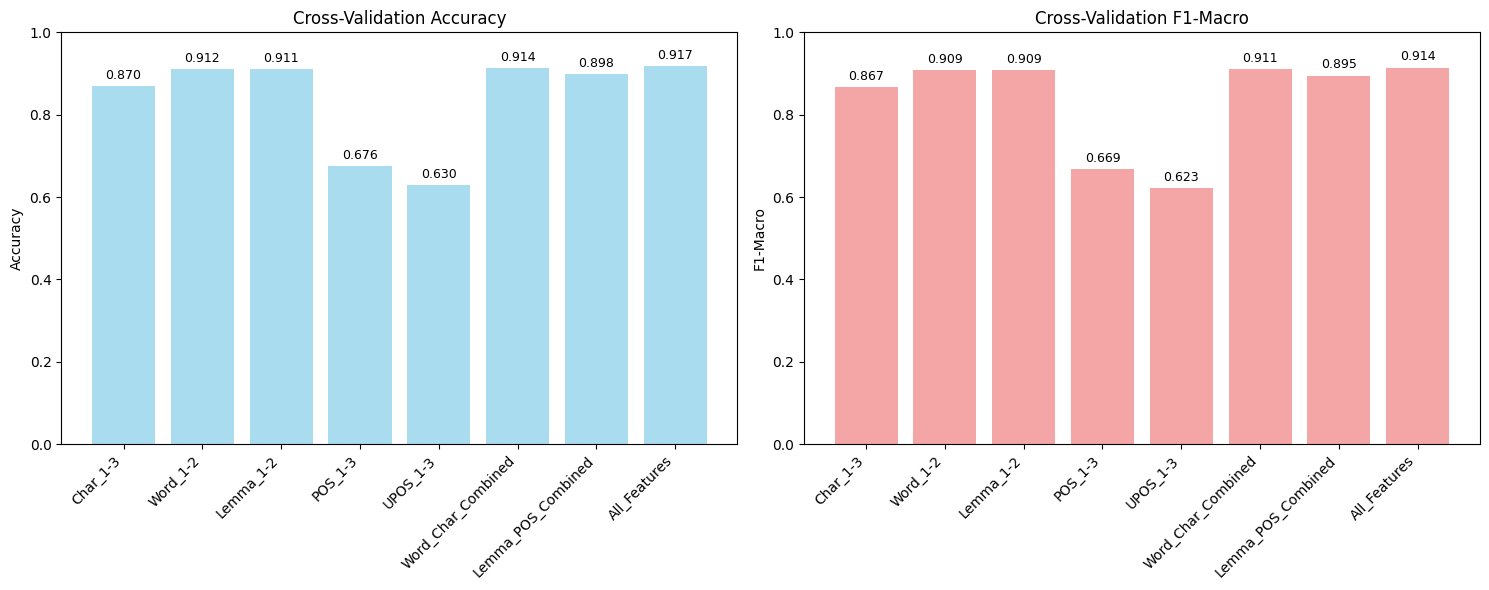


🏆 FASE 5: VALUTAZIONE CONFIGURAZIONE MIGLIORE
----------------------------------------
🔧 Training finale con configurazione: All_Features
🔧 Estrazione features con configurazione: All_Features
  🔽 Feature filtrate: 359875 → 81479 (min_docs=3)
  📊 Matrice features: (5505, 81479)
  👥 Distribuzione classi: {np.str_('primo autore'): np.int64(1802), np.str_('secondo autore'): np.int64(2151), np.str_('terzo autore'): np.int64(1552)}
🏋️  Training modello finale...
✅ Training completato!
  📊 Test set preparato: (479, 81479)
  📊 Eval set preparato: (481, 81479)

📈 FASE 6: RISULTATI FINALI
----------------------------------------

🏆 MIGLIORE CONFIGURAZIONE: All_Features
📊 Cross-Validation:
  🎯 Accuracy: 0.9172 ± 0.0056
  📊 F1-Macro: 0.9145 ± 0.0060
  📊 F1-Weighted: 0.9168 ± 0.0056

🧪 Test Set:
  🎯 Accuracy: 0.9019
  📊 F1-Macro: 0.8977
  📊 F1-Weighted: 0.9024

🎯 Eval Set:
  🎯 Accuracy: 0.9023
  📊 F1-Macro: 0.8953
  📊 F1-Weighted: 0.9017

📊 CLASSIFICATION REPORTS

🧪 TEST SET:
                prec

In [ ]:
# ============================================================================
# APPLICAZIONE COMPLETA SVM N-GRAMMI AUTHORSHIP ATTRIBUTION
# ============================================================================

def run_ngram_authorship_attribution(base_path):
    """
    Pipeline completa per authorship attribution con n-grammi

    Args:
        base_path: percorso alla cartella con training_set/, test_set/, eval_set/
    """

    print("🚀 INIZIO PIPELINE SVM N-GRAMMI AUTHORSHIP ATTRIBUTION")
    print("=" * 70)

    # ========================================================================
    # 1. CARICAMENTO DATI
    # ========================================================================

    print("\n📂 FASE 1: CARICAMENTO DATI")
    print("-" * 40)

    datasets = load_dataset_from_structure(base_path)

    train_docs = datasets['training_set']
    test_docs = datasets['test_set']
    eval_docs = datasets['eval_set']

    # Verifica autori
    all_authors = set()
    for docs in [train_docs, test_docs, eval_docs]:
        all_authors.update([doc.author for doc in docs])

    authors = sorted(list(all_authors))

    print(f"\n📊 RIEPILOGO DATASET:")
    print(f"  👥 Autori: {authors}")
    print(f"  🏋️  Training: {len(train_docs)} documenti")
    print(f"  🧪 Test: {len(test_docs)} documenti")
    print(f"  🎯 Eval: {len(eval_docs)} documenti")

    if len(train_docs) == 0:
        print("❌ ERRORE: Nessun documento di training trovato!")
        return

    # ========================================================================
    # 2. CONFIGURAZIONI SPERIMENTALI
    # ========================================================================

    print(f"\n⚙️  FASE 2: CONFIGURAZIONI SPERIMENTALI")
    print("-" * 40)

    configs = get_experimental_configurations()

    print(f"🔧 Configurazioni da testare: {len(configs)}")
    for i, config in enumerate(configs, 1):
        print(f"  {i}. {config['name']}")

    # ========================================================================
    # 3. CROSS-VALIDATION DELLE CONFIGURAZIONI
    # ========================================================================

    print(f"\n🔄 FASE 3: CROSS-VALIDATION SU TRAINING SET")
    print("-" * 40)

    all_results = []

    for i, config in enumerate(configs, 1):
        print(f"\n🧪 Test configurazione {i}/{len(configs)}: {config['name']}")

        try:
            # Prepara dati
            X_train, y_train, vectorizer, scaler = prepare_data_for_training(train_docs, config)

            # Cross-validation
            cv_results = cross_validate_config(X_train, y_train, config['name'])
            all_results.append(cv_results)

            # Stampa risultati brevi
            print(f"  ✅ CV Accuracy: {cv_results['cv_accuracy_mean']:.4f} ± {cv_results['cv_accuracy_std']:.4f}")
            print(f"  📊 CV F1-Macro: {cv_results['cv_f1_macro_mean']:.4f} ± {cv_results['cv_f1_macro_std']:.4f}")
            print(f"  🚀 Miglioramento: +{cv_results['improvement_accuracy']:.4f} (Acc), +{cv_results['improvement_f1_macro']:.4f} (F1)")

        except Exception as e:
            print(f"  ❌ Errore: {str(e)}")
            continue

    # ========================================================================
    # 4. CONFRONTO RISULTATI E SELEZIONE MIGLIOR CONFIGURAZIONE
    # ========================================================================

    print(f"\n📊 FASE 4: CONFRONTO RISULTATI")
    print("-" * 40)

    if not all_results:
        print("❌ ERRORE: Nessuna configurazione completata con successo!")
        return

    # Stampa tabella riassuntiva
    print_results_table(all_results)

    # Trova miglior configurazione
    best_config_result = find_best_configuration(all_results, 'cv_f1_macro_mean')
    best_config_name = best_config_result['config_name']

    # Trova configurazione corrispondente
    best_config = None
    for config in configs:
        if config['name'] == best_config_name:
            best_config = config
            break

    if best_config is None:
        print("❌ ERRORE: Configurazione migliore non trovata!")
        return

    # Visualizzazione grafica
    if len(all_results) > 1:
        plot_configuration_comparison(all_results)

    # ========================================================================
    # 5. TRAINING FINALE E VALUTAZIONE SU TEST/EVAL SET
    # ========================================================================

    print(f"\n🏆 FASE 5: VALUTAZIONE CONFIGURAZIONE MIGLIORE")
    print("-" * 40)

    print(f"🔧 Training finale con configurazione: {best_config['name']}")

    try:
        # Prepara dati training con miglior configurazione
        X_train, y_train, vectorizer, scaler = prepare_data_for_training(train_docs, best_config)

        # Training del modello finale
        print("🏋️  Training modello finale...")
        final_svm_model = train_svm_model(X_train, y_train)
        print("✅ Training completato!")

        # Prepara dati test e eval
        if test_docs:
            X_test, y_test = prepare_test_data(test_docs, vectorizer, scaler, best_config)
            print(f"  📊 Test set preparato: {X_test.shape}")
        else:
            X_test, y_test = np.array([]).reshape(0, X_train.shape[1]), np.array([])
            print("  ⚠️  Test set vuoto")

        if eval_docs:
            X_eval, y_eval = prepare_test_data(eval_docs, vectorizer, scaler, best_config)
            print(f"  📊 Eval set preparato: {X_eval.shape}")
        else:
            X_eval, y_eval = np.array([]).reshape(0, X_train.shape[1]), np.array([])
            print("  ⚠️  Eval set vuoto")

        # Valutazione finale
        final_results = evaluate_on_test_set(
            final_svm_model, X_test, y_test, X_eval, y_eval, best_config['name']
        )

        # ====================================================================
        # 6. RISULTATI FINALI
        # ====================================================================

        print(f"\n📈 FASE 6: RISULTATI FINALI")
        print("-" * 40)

        print(f"\n🏆 MIGLIORE CONFIGURAZIONE: {best_config['name']}")
        print(f"📊 Cross-Validation:")
        print(f"  🎯 Accuracy: {best_config_result['cv_accuracy_mean']:.4f} ± {best_config_result['cv_accuracy_std']:.4f}")
        print(f"  📊 F1-Macro: {best_config_result['cv_f1_macro_mean']:.4f} ± {best_config_result['cv_f1_macro_std']:.4f}")
        print(f"  📊 F1-Weighted: {best_config_result['cv_f1_weighted_mean']:.4f} ± {best_config_result['cv_f1_weighted_std']:.4f}")

        if X_test.shape[0] > 0:
            print(f"\n🧪 Test Set:")
            print(f"  🎯 Accuracy: {final_results['test_accuracy']:.4f}")
            print(f"  📊 F1-Macro: {final_results['test_f1_macro']:.4f}")
            print(f"  📊 F1-Weighted: {final_results['test_f1_weighted']:.4f}")

        if X_eval.shape[0] > 0:
            print(f"\n🎯 Eval Set:")
            print(f"  🎯 Accuracy: {final_results['eval_accuracy']:.4f}")
            print(f"  📊 F1-Macro: {final_results['eval_f1_macro']:.4f}")
            print(f"  📊 F1-Weighted: {final_results['eval_f1_weighted']:.4f}")

        # Classification report dettagliato
        show_classification_report(final_svm_model, X_test, y_test, X_eval, y_eval, authors)

        # ====================================================================
        # 7. ANALISI FEATURE IMPORTANTI
        # ====================================================================

        print(f"\n🔍 FASE 7: ANALISI FEATURE IMPORTANCE")
        print("-" * 40)

        analyze_feature_importance(final_svm_model, vectorizer, authors, top_n=15)

        print(f"\n✅ PIPELINE COMPLETATA!")
        print("=" * 70)

        return {
            'best_config': best_config,
            'final_model': final_svm_model,
            'vectorizer': vectorizer,
            'scaler': scaler,
            'results': {
                'cv_results': best_config_result,
                'final_results': final_results
            },
            'all_results': all_results
        }

    except Exception as e:
        print(f"❌ ERRORE nella valutazione finale: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

def analyze_feature_importance(svm_model, vectorizer, authors, top_n=15):
    """Analizza le feature più importanti per ogni autore"""

    feature_names = vectorizer.get_feature_names_out()
    coefs = svm_model.coef_

    print(f"🔍 TOP {top_n} FEATURE PIÙ DISCRIMINANTI:")
    print("-" * 50)

    for idx, author in enumerate(authors):
        print(f"\n📊 {author.upper()}:")

        # Coefficienti per questo autore
        author_coefs = coefs[idx] if len(coefs.shape) > 1 else coefs

        # Crea coppie (feature, coefficiente) e ordina per valore assoluto
        feature_importance = list(zip(feature_names, author_coefs))
        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

        # Mostra top N
        for i, (feature, coef) in enumerate(feature_importance[:top_n], 1):
            direction = "+" if coef > 0 else "-"
            print(f"  {i:2d}. {feature:<35} {direction} {abs(coef):.4f}")

# ============================================================================
# ESEMPIO DI UTILIZZO
# ============================================================================

def main_example():
    """Esempio di utilizzo della pipeline completa"""

    # MODIFICA QUESTO PERCORSO CON IL TUO!
    base_path = "/content/drive/MyDrive/16590/dataset_authorship_finale"

    # Per Google Colab, prima monta il drive:
    # from google.colab import drive
    # drive.mount('/content/drive')

    # Esegui pipeline completa
    results = run_ngram_authorship_attribution(base_path)

    if results:
        print("\n🎉 Pipeline completata con successo!")
        print(f"📊 Miglior configurazione: {results['best_config']['name']}")

        # Puoi accedere ai risultati:
        # - results['final_model']: modello SVM finale
        # - results['vectorizer']: vectorizer per nuove predizioni
        # - results['scaler']: scaler per normalizzazione
        # - results['all_results']: tutti i risultati delle configurazioni
    else:
        print("❌ Pipeline fallita!")

# ============================================================================
# PER ESEGUIRE SU COLAB
# ============================================================================

# Decomenta e modifica il percorso:
#
# from google.colab import drive
# drive.mount('/content/drive')
#
# # Imposta il tuo percorso
base_path = "/content/drive/MyDrive/libri_conlu/dataset_authorship_finale_profilato"
#
# # Esegui la pipeline
results = run_ngram_authorship_attribution(base_path)

In [ ]:
# ============================================================================
# DOWNLOAD FASTTEXT MODEL TO GOOGLE DRIVE
# ============================================================================
!pip install fasttext
import os
import shutil
import fasttext
import fasttext.util

# Configura percorsi
DRIVE_BASE = "/content/drive/MyDrive"
MODELS_DIR = os.path.join(DRIVE_BASE, "fasttext_models")
MODEL_NAME = "cc.en.300.bin"
MODEL_PATH = os.path.join(MODELS_DIR, MODEL_NAME)

# Crea directory se non esiste
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"📁 Directory modelli: {MODELS_DIR}")
print(f"🎯 Percorso modello: {MODEL_PATH}")

# Controlla se il modello esiste già
if os.path.exists(MODEL_PATH):
    print("✅ Il modello esiste già nel Drive!")
    print(f"📊 Dimensione file: {os.path.getsize(MODEL_PATH) / (1024**3):.2f} GB")

    # Carica il modello esistente
    print("⏳ Caricamento modello dal Drive...")
    ft = fasttext.load_model(MODEL_PATH)
    print(f"✅ Modello caricato! Dimensione vettore: {ft.get_dimension()}")

else:
    print("🔄 Il modello non esiste, procedo con il download...")

    # Download temporaneo nella directory di default
    print("⏳ Download in corso... (questo può richiedere diversi minuti)")
    fasttext.util.download_model('en', if_exists='ignore')

    # Trova il file scaricato
    temp_model_path = MODEL_NAME  # FastText scarica nella directory corrente

    if os.path.exists(temp_model_path):
        print(f"✅ Download completato!")
        print(f"📊 Dimensione file: {os.path.getsize(temp_model_path) / (1024**3):.2f} GB")

        # Sposta nel Drive
        print(f"🚚 Spostamento nel Drive: {MODEL_PATH}")
        shutil.move(temp_model_path, MODEL_PATH)
        print("✅ Modello salvato nel Drive!")

        # Carica il modello
        print("⏳ Caricamento modello...")
        ft = fasttext.load_model(MODEL_PATH)
        print(f"✅ Modello caricato! Dimensione vettore: {ft.get_dimension()}")

    else:
        print("❌ Errore: file del modello non trovato dopo il download")
        ft = None

# Test del modello
if 'ft' in locals() and ft is not None:
    print("\n🧪 TEST DEL MODELLO:")
    print("-" * 40)

    test_words = ["author", "writing", "style", "book", "novel"]

    for word in test_words:
        try:
            vec = ft.get_word_vector(word)
            print(f"✅ '{word}': shape {vec.shape}, sample: {vec[:3].round(3)}")
        except Exception as e:
            print(f"❌ Errore con '{word}': {e}")

    print(f"\n📈 Vocabolario: ~{len(ft.get_words())} parole")
    print(f"🔤 Dimensione embedding: {ft.get_dimension()}")

    # Funzione helper per uso futuro
    def get_embeddings_dict(model, words_list):
        """Crea dizionario embeddings per una lista di parole"""
        embeddings = {}
        for word in words_list:
            embeddings[word] = model.get_word_vector(word)
        return embeddings

    print("\n💡 Per usare il modello in futuro:")
    print(f"ft = fasttext.load_model('{MODEL_PATH}')")
    print("embeddings = get_embeddings_dict(ft, your_vocabulary)")

else:
    print("❌ Modello non disponibile")

print(f"\n📍 Modello salvato in: {MODEL_PATH}")
print("🔄 Il modello rimarrà nel tuo Drive per usi futuri!")

📁 Directory modelli: /content/drive/MyDrive/fasttext_models
🎯 Percorso modello: /content/drive/MyDrive/fasttext_models/cc.en.300.bin
✅ Il modello esiste già nel Drive!
📊 Dimensione file: 6.74 GB
⏳ Caricamento modello dal Drive...
✅ Modello caricato! Dimensione vettore: 300

🧪 TEST DEL MODELLO:
----------------------------------------
✅ 'author': shape (300,), sample: [-0.026  0.06   0.004]
✅ 'writing': shape (300,), sample: [-0.007  0.025  0.056]
✅ 'style': shape (300,), sample: [0.097 0.014 0.039]
✅ 'book': shape (300,), sample: [-0.123  0.105  0.035]
✅ 'novel': shape (300,), sample: [-0.04   0.02   0.101]

📈 Vocabolario: ~2000000 parole
🔤 Dimensione embedding: 300

💡 Per usare il modello in futuro:
ft = fasttext.load_model('/content/drive/MyDrive/fasttext_models/cc.en.300.bin')
embeddings = get_embeddings_dict(ft, your_vocabulary)

📍 Modello salvato in: /content/drive/MyDrive/fasttext_models/cc.en.300.bin
🔄 Il modello rimarrà nel tuo Drive per usi futuri!


In [ ]:
# ============================================================================
# CLASSIFICATORE SVM CON WORD EMBEDDINGS - AUTORE ADATTATO PER TOKEN SENZA POS
# ============================================================================

import os
import fasttext
import numpy as np
from collections import Counter, namedtuple
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier

# ======= STRUTTURE DATI =======
Token = namedtuple('Token', ['word', 'pos'])  # pos ignorato
Document = namedtuple('Document', ['tokens', 'author', 'split'])

# ======= CARICAMENTO DATI =======
def load_documents(dataset_path):
    documents = []
    set_mapping = {'training_set': 'training', 'test_set': 'test', 'eval_set': 'eval'}

    for set_name, split in set_mapping.items():
        set_path = os.path.join(dataset_path, set_name)
        if not os.path.exists(set_path):
            continue
        for author in os.listdir(set_path):
            author_path = os.path.join(set_path, author)
            if not os.path.isdir(author_path):
                continue
            for fname in os.listdir(author_path):
                if fname.endswith('.txt'):
                    with open(os.path.join(author_path, fname), 'r', encoding='utf-8') as f:
                        text = f.read().strip()
                    words = [w.strip('.,!?":;()[]{}').lower() for w in text.split() if w.strip('.,!?":;()[]{}')]
                    if len(words) > 10:
                        tokens = [Token(word=w, pos='WORD') for w in words]
                        documents.append(Document(tokens=tokens, author=author, split=split))s
    return documents

# ======= VOCABOLARIO E EMBEDDINGS =======
def extract_vocab(documents, min_freq=2):
    counter = Counter()
    for doc in documents:
        for token in doc.tokens:
            counter[token.word] += 1
    return [w for w, c in counter.items() if c >= min_freq]

def create_embeddings_dict(ft_model, vocab):
    return {w: ft_model.get_word_vector(w) for w in vocab}

# ======= CONFIGURAZIONI EMBEDDINGS =======
def get_configs():
    return [
        {'name': 'Mean_All_Words', 'method': 'mean'},
        {'name': 'Max_Pooling', 'method': 'max'},
        {'name': 'Sum_All_Words', 'method': 'sum'}
    ]

# ======= ESTRAZIONE FEATURES =======
def extract_features(doc, embeddings, config):
    vectors = [embeddings[t.word] for t in doc.tokens if t.word in embeddings]
    if not vectors:
        return np.zeros(300)  # FastText dimension
    arr = np.array(vectors)
    if config['method'] == 'mean':
        return np.mean(arr, axis=0)
    elif config['method'] == 'max':
        return np.max(arr, axis=0)
    elif config['method'] == 'sum':
        return np.sum(arr, axis=0)

# ======= PREPARAZIONE DATI =======
def prepare_data(docs, embeddings, config):
    X, y = [], []
    for doc in docs:
        X.append(extract_features(doc, embeddings, config))
        y.append(doc.author)
    return np.array(X), np.array(y)

# ======= CROSS-VALIDATION =======
def cross_validate_model(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    svm = LinearSVC(dual=False, max_iter=5000, class_weight='balanced', random_state=42)
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    scoring = ['accuracy', 'f1_macro']
    cv_results = cross_validate(svm, X_scaled, y, cv=cv, scoring=scoring)
    baseline = DummyClassifier(strategy='most_frequent', random_state=42)
    baseline_results = cross_validate(baseline, X_scaled, y, cv=cv, scoring=['accuracy'])
    return cv_results, baseline_results, scaler

# ======= ESPERIMENTO PRINCIPALE =======
def run_experiment(documents, embeddings):
    train_docs = [d for d in documents if d.split=='training']
    test_docs = [d for d in documents if d.split=='test']
    eval_docs = [d for d in documents if d.split=='eval']

    configs = get_configs()
    results = []

    for config in configs:
        X_train, y_train = prepare_data(train_docs, embeddings, config)
        cv_res, base_res, scaler = cross_validate_model(X_train, y_train)

        res = {
            'config': config['name'],
            'cv_acc': cv_res['test_accuracy'].mean(),
            'cv_f1': cv_res['test_f1_macro'].mean(),
            'baseline_acc': base_res['test_accuracy'].mean(),
            'improvement': cv_res['test_accuracy'].mean() - base_res['test_accuracy'].mean(),
            'scaler': scaler,
            'X_train': X_train,
            'y_train': y_train
        }
        results.append(res)
        print(f"{config['name']}: CV Acc={res['cv_acc']:.3f}, F1={res['cv_f1']:.3f}, +{res['improvement']:.3f}")

    best = max(results, key=lambda x: x['cv_f1'])
    print(f"\nBest config: {best['config']}")

    # Training finale e test
    X_train_scaled = best['scaler'].fit_transform(best['X_train'])
    final_model = LinearSVC(dual=False, max_iter=5000, class_weight='balanced', random_state=42)
    final_model.fit(X_train_scaled, best['y_train'])

    for dataset, docs in [('Test', test_docs), ('Eval', eval_docs)]:
        if docs:
            X = np.array([extract_features(d, embeddings, next(c for c in configs if c['name']==best['config'])) for d in docs])
            y = np.array([d.author for d in docs])
            X_scaled = best['scaler'].transform(X)
            pred = final_model.predict(X_scaled)
            acc = accuracy_score(y, pred)
            f1 = f1_score(y, pred, average='macro')
            print(f"{dataset} - Acc={acc:.3f}, F1={f1:.3f}")
            print(classification_report(y, pred))

    return best, final_model

# ======= MAIN =======
def main():
    dataset_path = "/content/drive/MyDrive/dataset_authorship_finale"
    documents = load_documents(dataset_path)
    print(f"Loaded {len(documents)} documents")

    ft_model = fasttext.load_model("/content/drive/MyDrive/fasttext_models/cc.en.300.bin")
    vocab = extract_vocab(documents)
    embeddings = create_embeddings_dict(ft_model, vocab)

    best_config, final_model = run_experiment(documents, embeddings)
    print(f"\n✅ Experiment finished! Best config: {best_config['config']}")

if __name__ == "__main__":
    main()


Loaded 6492 documents
Mean_All_Words: CV Acc=0.785, F1=0.781, +0.400
Max_Pooling: CV Acc=0.685, F1=0.679, +0.301
Sum_All_Words: CV Acc=0.788, F1=0.784, +0.403

Best config: Sum_All_Words
Test - Acc=0.859, F1=0.856
                precision    recall  f1-score   support

  primo autore       0.92      0.84      0.88       213
secondo autore       0.77      0.93      0.84       141
  terzo autore       0.88      0.81      0.85       129

      accuracy                           0.86       483
     macro avg       0.86      0.86      0.86       483
  weighted avg       0.87      0.86      0.86       483

Eval - Acc=0.860, F1=0.855
                precision    recall  f1-score   support

  primo autore       0.93      0.84      0.88       213
secondo autore       0.82      0.92      0.86       142
  terzo autore       0.81      0.83      0.82       129

      accuracy                           0.86       484
     macro avg       0.85      0.86      0.86       484
  weighted avg       0.86 